In [1]:
#Basic Modules
import pandas as pd
import numpy as np
#plots
import seaborn as sns
import plotly.graph_objects as go
#Data Handling
from sklearn.preprocessing import (Normalizer,StandardScaler,MinMaxScaler)
# Genetic Modules
from gplearn.genetic import SymbolicTransformer
from sklearn.ensemble import RandomForestClassifier
from matplotlib import rcParams
from cycler import cycler
#Log Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, accuracy_score, recall_score, precision_score,
                             f1_score,balanced_accuracy_score)
#Naive Bayes
from sklearn.naive_bayes import GaussianNB, CategoricalNB
# metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
# Neural Network
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model
import matplotlib.pyplot as plt

# <font color= #6B6B6B> 1. Data Description </font>

Description of datasets and info used, info from january 1st 2021 to end of september 2022, ohlc of prices from binance, BTCUSDT. for trials a dataset from only august is used, frequency is per minute.

data obtained from https://data.binance.vision/?prefix=data/spot/monthly/klines/BTCUSDT/1m/

In [13]:
route = 'C:/Users/Emilio/Desktop/TOG Exp/Datasets/'
# data = pd.read_parquet(route+'ohlcV.parquet')
# data = pd.read_parquet(route+'ohlc-2017.parquet')
data = pd.read_parquet(route + 'ohlc-2021.parquet')
# data = pd.read_parquet(route + 'ohlc1.parquet')
data = data.drop(['drop', 'close_time'], axis=1)
data.head()

open      high       low     close     volume  \
timestamp                                                                
2021-01-01 00:00:00  28923.63  28961.66  28913.12  28961.66  27.457032   
2021-01-01 00:01:00  28961.67  29017.50  28961.01  29009.91  58.477501   
2021-01-01 00:02:00  29009.54  29016.71  28973.58  28989.30  42.470329   
2021-01-01 00:03:00  28989.68  28999.85  28972.33  28982.69  30.360677   
2021-01-01 00:04:00  28982.67  28995.93  28971.80  28975.65  24.124339   

                     quote_asset_volume  trades  buy_asset_volume  \
timestamp                                                           
2021-01-01 00:00:00        7.943820e+05    1292         16.777195   
2021-01-01 00:01:00        1.695803e+06    1651         33.733818   
2021-01-01 00:02:00        1.231359e+06     986         13.247444   
2021-01-01 00:03:00        8.800168e+05     959          9.456028   
2021-01-01 00:04:00        6.992262e+05     726          6.814644   

                     taker_buy_asset_volume  
timestamp                                    
2021-01-01 00:00:00           485390.826825  
2021-01-01 00:01:00           978176.468202  
2021-01-01 00:02:00           384076.854453  
2021-01-01 00:03:00           274083.075142  
2021-01-01 00:04:00           197519.374888

In [16]:
print(data.shape)
print(data.isnull().sum())

(917727, 9)
open                      0
high                      0
low                       0
close                     0
volume                    0
quote_asset_volume        0
trades                    0
buy_asset_volume          0
taker_buy_asset_volume    0
dtype: int64


In [17]:
# %% Quick description of the data
desc = data.describe()
info = data.info()
print(desc, info)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 917727 entries, 2021-01-01 00:00:00 to 2022-09-30 23:59:00
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   open                    917727 non-null  float64
 1   high                    917727 non-null  float64
 2   low                     917727 non-null  float64
 3   close                   917727 non-null  float64
 4   volume                  917727 non-null  float64
 5   quote_asset_volume      917727 non-null  float64
 6   trades                  917727 non-null  int64  
 7   buy_asset_volume        917727 non-null  float64
 8   taker_buy_asset_volume  917727 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 70.0 MB
                open           high            low          close  \
count  917727.000000  917727.000000  917727.000000  917727.000000   
mean    40625.624820   40653.629847   40597.770063   40625.612126   
std 

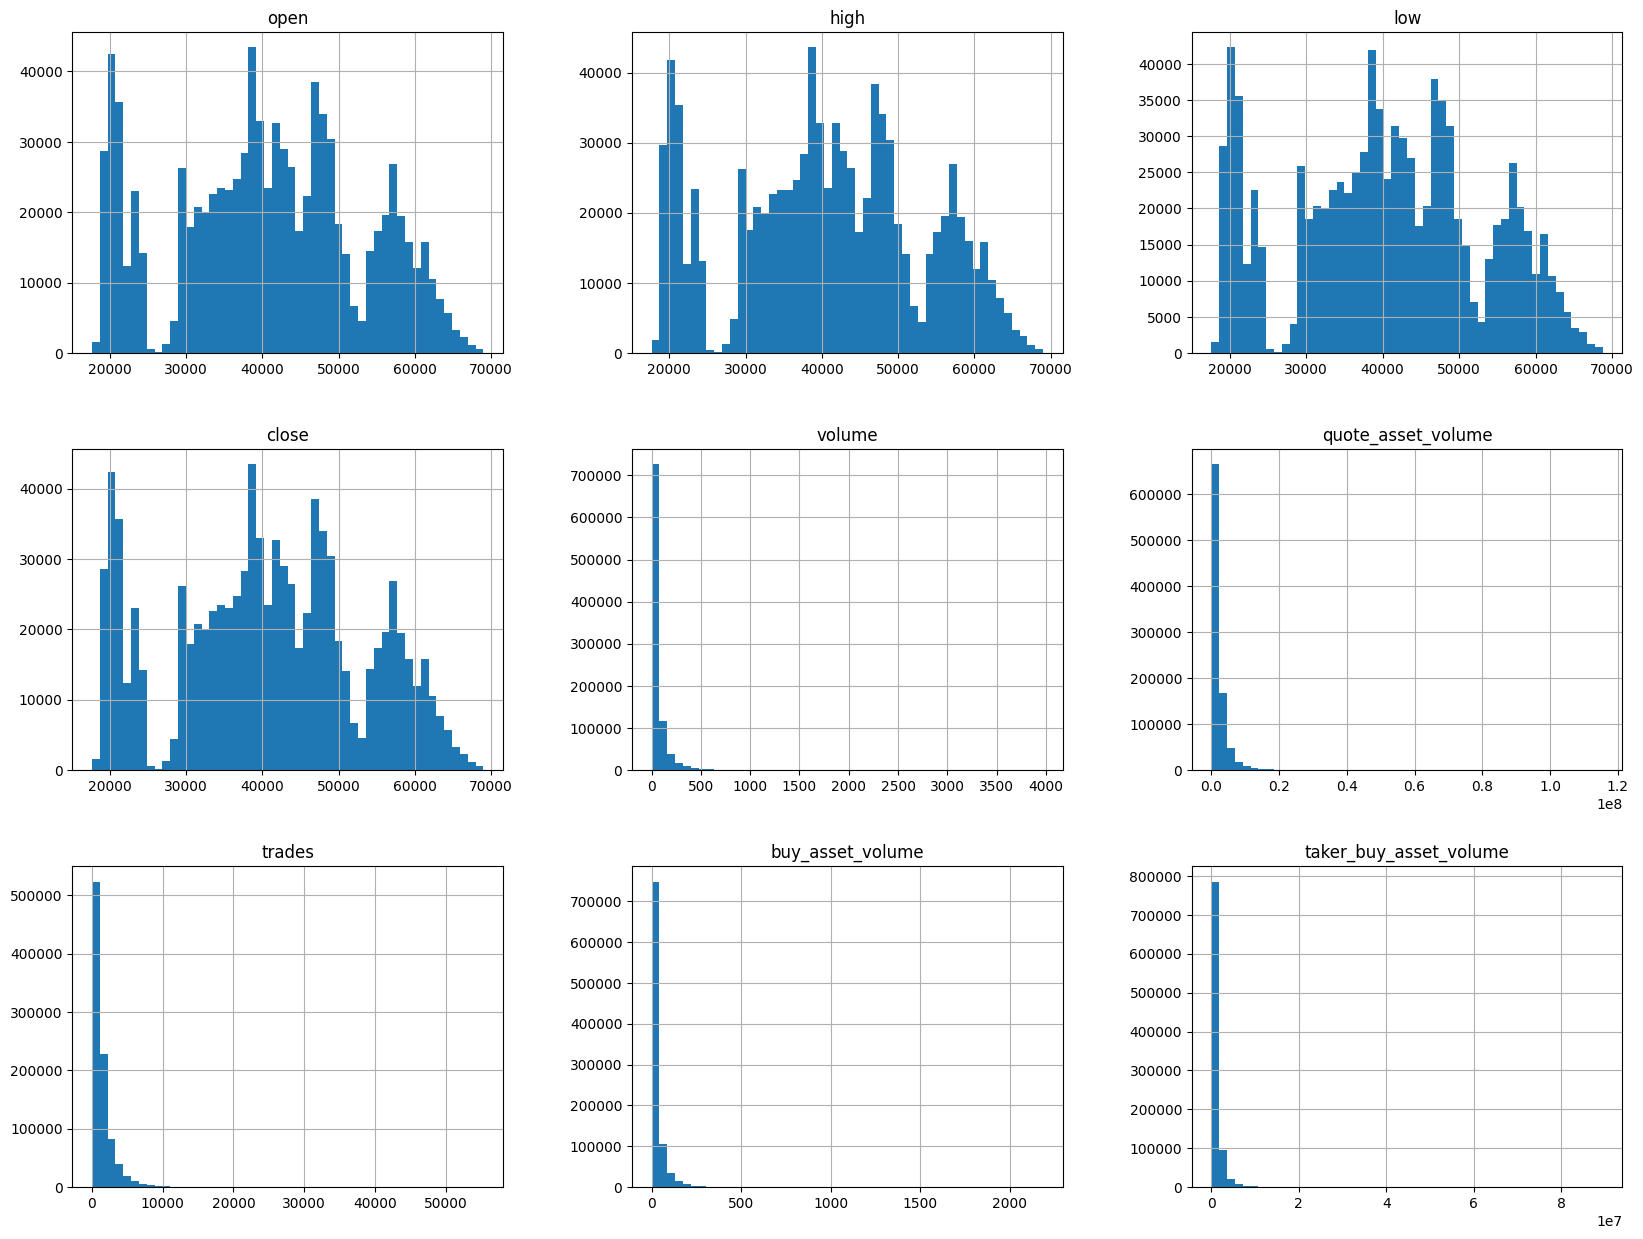

<AxesSubplot:xlabel='timestamp'>

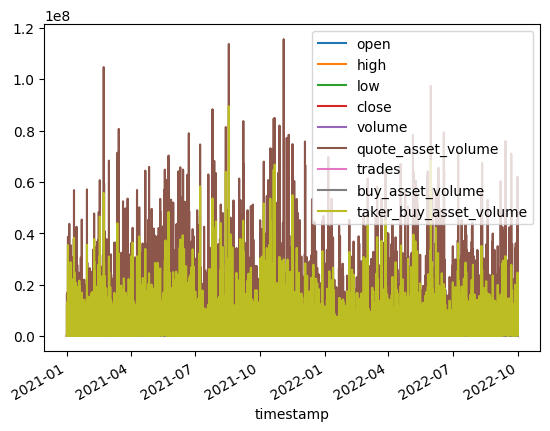

In [5]:
# %%
# %matplotlib inline
data.hist(bins=50, figsize=(20, 15))
plt.show()

data.plot()

Description of variables:

Timestamp = time series serving as index, it goes in intervals of 1 minute, from the beggining of 2022, until the end of august.
OHLC variables , this are numeric , based on the prices of the cross between BTC and USDT

Open is a numeric variable, expressing the first price, at the beginning of the epoch.
High is a numeric variable, expressing the max value of the epoch.
Low is the variable expressing the min value of the epoch observed.
Close is the last value of the epoch.
Volume variables, numeric serve as the total quantity observed on the epoch.

Next we do a resampling, to transform the series from micro time to intra day , the period chosen was 1 hour

In [18]:
# %% Resampling
rs = '1H'
data1 = data.copy()
data1['open'] = data1['open'].resample(rs).first()
data1['high'] = data1['high'].resample(rs).max()
data1['low'] = data1['low'].resample(rs).min()
data1['close'] = data1['close'].resample(rs).last()
data1['volume'] = data1['volume'].resample(rs).sum()
data1['quote_asset_volume'] = data1['quote_asset_volume'].resample(rs).sum()
data1['trades'] = data1['trades'].resample(rs).sum()
data1['buy_asset_volume'] = data1['buy_asset_volume'].resample(rs).sum()
data1['taker_buy_asset_volume'] = data1['taker_buy_asset_volume'].resample(rs).sum()
data1 = data1.resample(rs).sum()
print(data1.shape)
data1.head()


(15312, 9)


open      high       low     close       volume  \
timestamp                                                                  
2021-01-01 00:00:00  28923.63  29031.34  28690.17  28995.13  2311.811445   
2021-01-01 01:00:00  28995.13  29470.00  28960.35  29409.99  5403.068471   
2021-01-01 02:00:00  29410.00  29465.26  29120.03  29194.65  2384.231560   
2021-01-01 03:00:00  29195.25  29367.00  29150.02  29278.40  1461.345077   
2021-01-01 04:00:00  29278.41  29395.00  29029.40  29220.31  2038.046803   

                     quote_asset_volume    trades  buy_asset_volume  \
timestamp                                                             
2021-01-01 00:00:00        6.676883e+07   58389.0       1215.359238   
2021-01-01 01:00:00        1.583578e+08  103896.0       3160.041701   
2021-01-01 02:00:00        6.984265e+07   57646.0       1203.433506   
2021-01-01 03:00:00        4.276078e+07   42510.0        775.915666   
2021-01-01 04:00:00        5.961464e+07   55414.0       1003.342834   

                     taker_buy_asset_volume  
timestamp                                    
2021-01-01 00:00:00            3.510354e+07  
2021-01-01 01:00:00            9.261399e+07  
2021-01-01 02:00:00            3.525275e+07  
2021-01-01 03:00:00            2.270555e+07  
2021-01-01 04:00:00            2.934638e+07

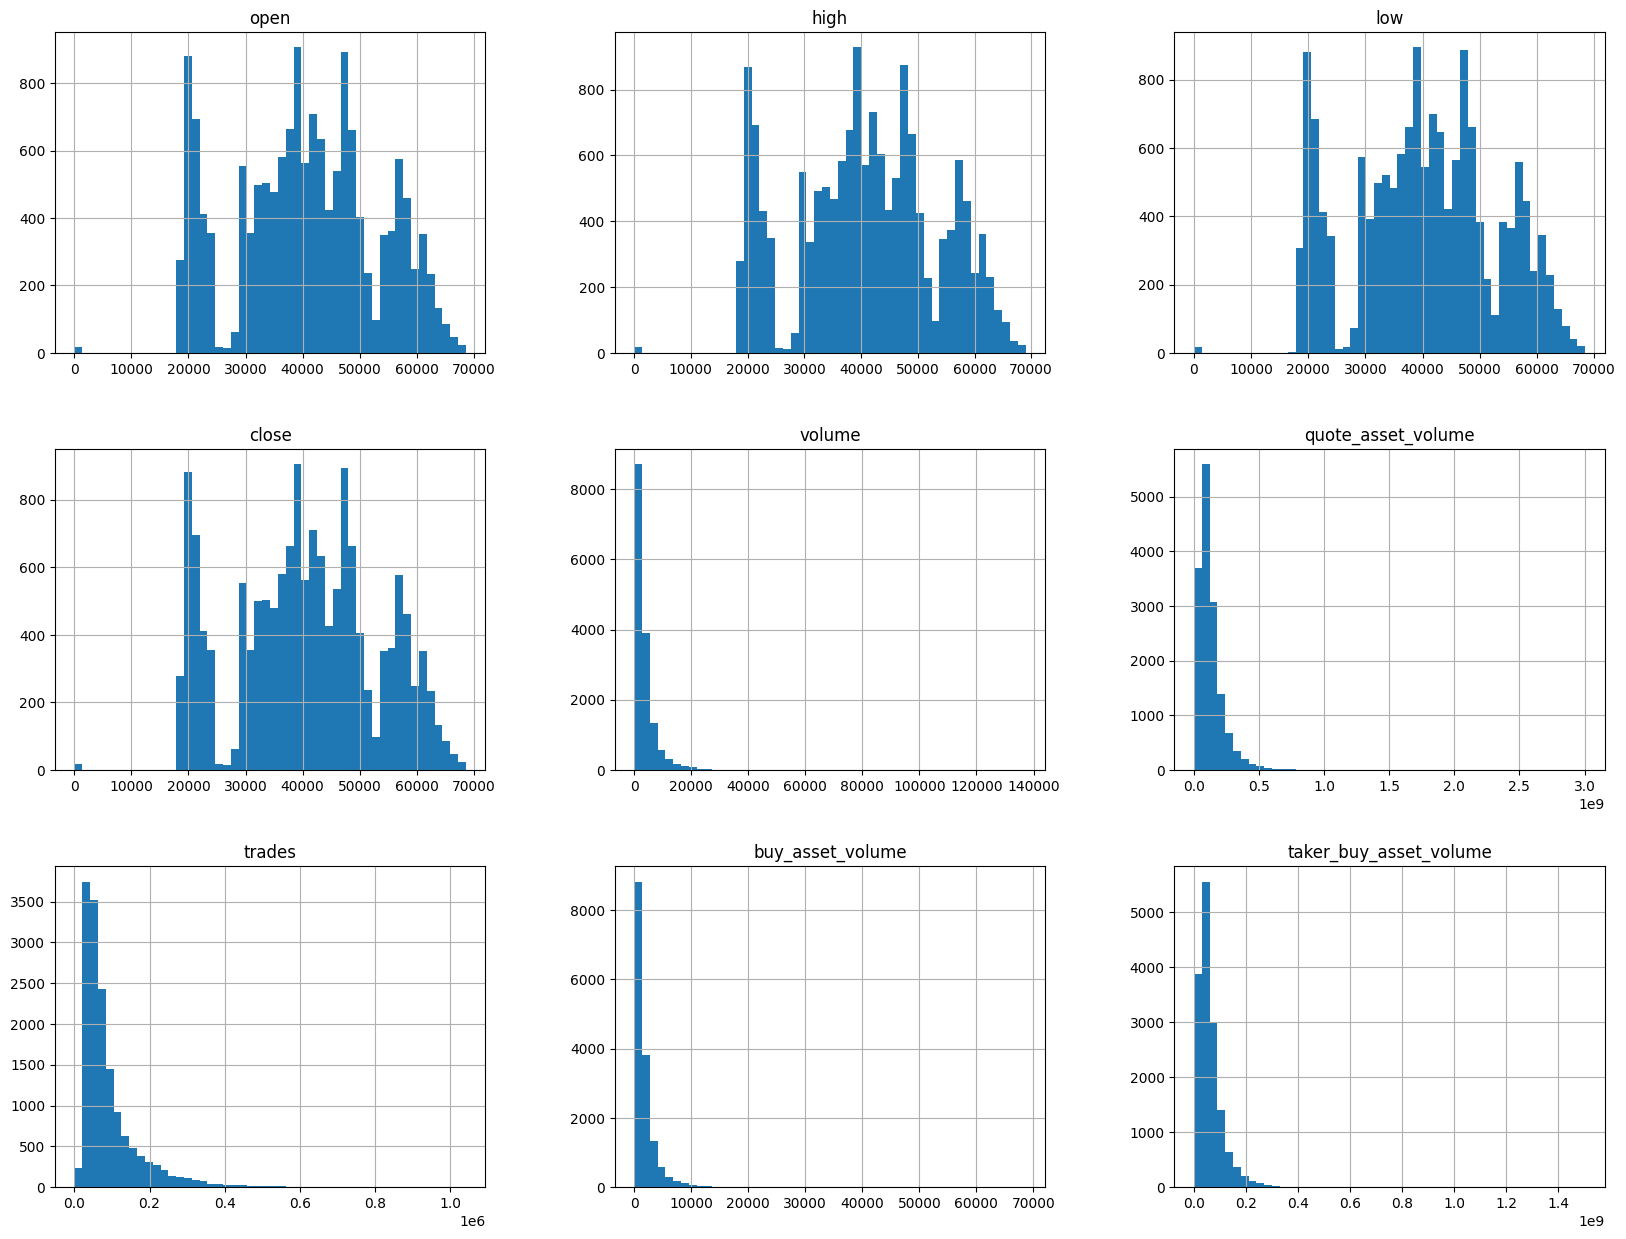

<AxesSubplot:xlabel='timestamp'>

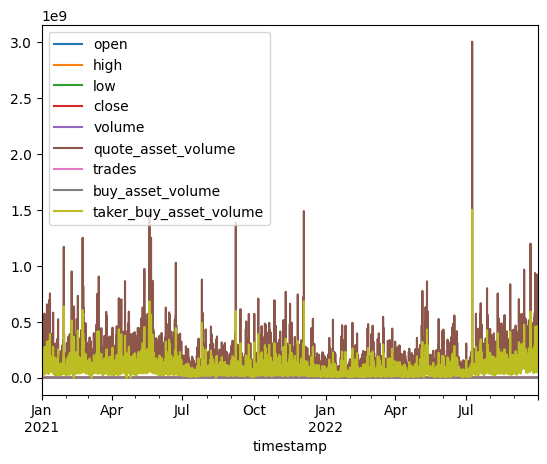

In [10]:
data1.hist(bins=50, figsize=(20, 15))
plt.show()

data1.plot()

<AxesSubplot:xlabel='timestamp'>

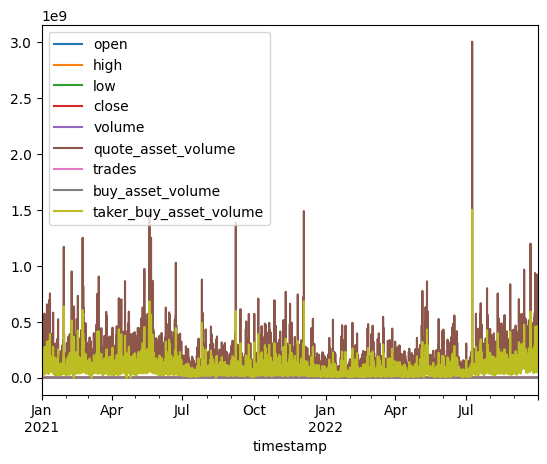

In [7]:
data1.plot()

In [11]:
# %% Feature Engineering

ohlcv = data1.copy()
# OHLC Chart
fig = go.Figure(data=go.Ohlc(x=ohlcv.index,
                             open=ohlcv['open'],
                             high=ohlcv['high'],
                             low=ohlcv['low'],
                             close=ohlcv['close']))

fig.show()


# <font color= #6B6B6B> 2. Feature Engineering </font>

#### FEATURES BASIC STATISTICS:
Next we will create the first features based on the OHLCV dataset.
* Volatility(HL):  $ V_t=H_t-L_t$
* High - open(HO): $ HO_t=H_t-O_t$
* Open - low(OL):  $ OL_t=O_t-L_t$
* High - Low(HL):  $ HL_t=H_t-L_t $
* Close - Open(CO): $CO_t=C_t-O_t$


In [19]:
# Volatility
volatility = []
for i in range(len(ohlcv)):
    vol = ohlcv['high'][i] - ohlcv['low'][i]
    volatility.append(vol)
ohlcv['volatility'] = volatility

# micro trends
high_open = []
for i in range(len(ohlcv)):
    ho = ohlcv['high'][i] - ohlcv['open'][i]
    high_open.append(ho)
ohlcv['high_open'] = high_open

open_low = []
for i in range(len(ohlcv)):
    ol = ohlcv['open'][i] - ohlcv['low'][i]
    open_low.append(ol)
ohlcv['open_low'] = open_low

close_open = []
for i in range(len(ohlcv)):
    co = ohlcv['close'][i] - ohlcv['open'][i]
    close_open.append(co)
ohlcv['close_open'] = close_open
ohlcv.head()

ohlcv2 = ohlcv.copy()
ohlcv2.head()

open      high       low     close       volume  \
timestamp                                                                  
2021-01-01 00:00:00  28923.63  29031.34  28690.17  28995.13  2311.811445   
2021-01-01 01:00:00  28995.13  29470.00  28960.35  29409.99  5403.068471   
2021-01-01 02:00:00  29410.00  29465.26  29120.03  29194.65  2384.231560   
2021-01-01 03:00:00  29195.25  29367.00  29150.02  29278.40  1461.345077   
2021-01-01 04:00:00  29278.41  29395.00  29029.40  29220.31  2038.046803   

                     quote_asset_volume    trades  buy_asset_volume  \
timestamp                                                             
2021-01-01 00:00:00        6.676883e+07   58389.0       1215.359238   
2021-01-01 01:00:00        1.583578e+08  103896.0       3160.041701   
2021-01-01 02:00:00        6.984265e+07   57646.0       1203.433506   
2021-01-01 03:00:00        4.276078e+07   42510.0        775.915666   
2021-01-01 04:00:00        5.961464e+07   55414.0       1003.342834   

                     taker_buy_asset_volume  volatility  high_open  open_low  \
timestamp                                                                      
2021-01-01 00:00:00            3.510354e+07      341.17     107.71    233.46   
2021-01-01 01:00:00            9.261399e+07      509.65     474.87     34.78   
2021-01-01 02:00:00            3.525275e+07      345.23      55.26    289.97   
2021-01-01 03:00:00            2.270555e+07      216.98     171.75     45.23   
2021-01-01 04:00:00            2.934638e+07      365.60     116.59    249.01   

                     close_open  
timestamp                        
2021-01-01 00:00:00       71.50  
2021-01-01 01:00:00      414.86  
2021-01-01 02:00:00     -215.35  
2021-01-01 03:00:00       83.15  
2021-01-01 04:00:00      -58.10

In [20]:
# %% Rolling stats
ohlcv2 = ohlcv2.drop(['quote_asset_volume', 'buy_asset_volume', 'taker_buy_asset_volume', 'trades'], axis=1)


def autoregressive_features(p_data, p_memory):
    """
    Creacion de variables de naturaleza autoregresiva (resagos, promedios, diferencias)
    Parameters
    ----------
    p_data: pd.DataFrame
        with OHLCV columns: Open, High, Low, Close, Volume
    p_memory: int
        A value that represents the implicit assumption of a "memory" effect in the prices
    Returns
    -------
    r_features: pd.DataFrame

    """

    # work with a separate copy of original data
    data = ohlcv2.copy()

    # nth-period final price "movement"
    data['co'] = (data['close'] - data['open'])
    # nth-period uptrend movement
    data['ho'] = (data['high'] - data['open'])
    # nth-period downtrend movement
    data['ol'] = (data['open'] - data['low'])
    # nth-period volatility measure
    data['hl'] = (data['high'] - data['low'])

    # N features with window-based calculations
    for n in range(0, p_memory):
        data['ma_ol'] = data['ol'].rolling(n + 2).mean()
        data['ma_ho'] = data['ho'].rolling(n + 2).mean()
        data['ma_hl'] = data['hl'].rolling(n + 2).mean()

        data['lag_ol_' + str(n + 1)] = data['ol'].shift(n + 1)
        data['lag_ho_' + str(n + 1)] = data['ho'].shift(n + 1)
        data['lag_hl_' + str(n + 1)] = data['hl'].shift(n + 1)

        data['sd_ol_' + str(n + 1)] = data['ol'].rolling(n + 1).std()
        data['sd_ho_' + str(n + 1)] = data['ho'].rolling(n + 1).std()
        data['sd_hl_' + str(n + 1)] = data['hl'].rolling(n + 1).std()

        data['lag_vol_' + str(n + 1)] = data['volume'].shift(n + 1)
        data['sum_vol_' + str(n + 1)] = data['volume'].rolling(n + 1).sum()
        data['mean_vol_' + str(n + 1)] = data['volume'].rolling(n + 1).mean()

    # timestamp as index
    data.index = pd.to_datetime(data.index)
    # select columns, drop for NAs, change column types, reset index
    r_features = data.drop(['open', 'high', 'low', 'close', 'hl', 'ol', 'ho', 'volume'], axis=1)
    r_features = r_features.dropna(axis='columns', how='all')
    # r_features = r_features.dropna(axis='rows')
    r_features.iloc[:, 1:] = r_features.iloc[:, 1:].astype(float)
    r_features.reset_index(inplace=True, drop=True)

    return r_features

In [21]:
p_memory = 24
data_ar = autoregressive_features(p_data=ohlcv2, p_memory=p_memory)
data_ar.index = ohlcv2.index

C:\Users\Emilio\AppData\Local\Temp\ipykernel_4660\47143235.py:40: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\Emilio\AppData\Local\Temp\ipykernel_4660\47143235.py:42: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\Emilio\AppData\Local\Temp\ipykernel_4660\47143235.py:43: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fra

C:\Users\Emilio\AppData\Local\Temp\ipykernel_4660\47143235.py:42: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\Emilio\AppData\Local\Temp\ipykernel_4660\47143235.py:43: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\Emilio\AppData\Local\Temp\ipykernel_4660\47143235.py:44: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fra

In [23]:
ohlcv = pd.merge(ohlcv, data_ar, on='timestamp')
ohlcv = ohlcv.dropna(axis='rows')
ohlcv

open      high       low     close        volume  \
timestamp                                                                   
2021-01-02 00:00:00  29331.70  29338.59  28946.53  29197.48   2638.159379   
2021-01-02 01:00:00  29197.93  29400.00  29100.00  29359.47   1891.997249   
2021-01-02 02:00:00  29359.46  29469.00  29320.01  29323.82   1704.830137   
2021-01-02 03:00:00  29323.82  29382.49  29256.85  29351.95   1158.041761   
2021-01-02 04:00:00  29351.95  29396.00  29220.00  29349.63    988.711070   
...                       ...       ...       ...       ...           ...   
2022-09-30 19:00:00  19666.83  19768.19  19470.29  19473.52  18501.284980   
2022-09-30 20:00:00  19473.52  19542.72  19355.00  19424.31  18638.811160   
2022-09-30 21:00:00  19424.31  19425.47  19284.85  19361.07   8501.140460   
2022-09-30 22:00:00  19359.77  19400.14  19240.44  19384.86  13559.584800   
2022-09-30 23:00:00  19384.86  19475.40  19358.67  19422.61   9858.755800   

                     quote_asset_volume    trades  buy_asset_volume  \
timestamp                                                             
2021-01-02 00:00:00        7.685653e+07   56787.0       1247.246187   
2021-01-02 01:00:00        5.538540e+07   41136.0        960.492001   
2021-01-02 02:00:00        5.011146e+07   34864.0        919.102507   
2021-01-02 03:00:00        3.396312e+07   33338.0        563.832243   
2021-01-02 04:00:00        2.898578e+07   36593.0        513.998514   
...                                 ...       ...               ...   
2022-09-30 19:00:00        3.636273e+08  274462.0       8643.900630   
2022-09-30 20:00:00        3.623093e+08  289474.0       9152.090890   
2022-09-30 21:00:00        1.646810e+08  148750.0       4056.893540   
2022-09-30 22:00:00        2.621486e+08  179442.0       6621.492300   
2022-09-30 23:00:00        1.914872e+08  124721.0       5059.940130   

                     taker_buy_asset_volume  volatility_x  ...  mean_vol_23_y  \
timestamp                                                  ...                  
2021-01-02 00:00:00            3.633083e+07        392.06  ...    2135.052368   
2021-01-02 01:00:00            2.812747e+07        300.00  ...    2113.650877   
2021-01-02 02:00:00            2.701882e+07        148.99  ...    2124.237184   
2021-01-02 03:00:00            1.653632e+07        125.64  ...    2085.976095   
2021-01-02 04:00:00            1.506982e+07        176.00  ...    2065.052391   
...                                     ...           ...  ...            ...   
2022-09-30 19:00:00            1.699307e+08        297.90  ...   18430.591535   
2022-09-30 20:00:00            1.779168e+08        187.72  ...   19010.081223   
2022-09-30 21:00:00            7.859082e+07        140.62  ...   18860.046038   
2022-09-30 22:00:00            1.280273e+08        159.70  ...   18889.747722   
2022-09-30 23:00:00            9.828441e+07        116.73  ...   18383.229670   

                     lag_ol_24_y  lag_ho_24_y  lag_hl_24_y  sd_ol_24_y  \
timestamp                                                                
2021-01-02 00:00:00       233.46       107.71       341.17  134.140353   
2021-01-02 01:00:00        34.78       474.87       509.65  132.097438   
2021-01-02 02:00:00       289.97        55.26       345.23  131.832421   
2021-01-02 03:00:00        45.23       171.75       216.98  131.108914   
2021-01-02 04:00:00       249.01       116.59       365.60  129.714368   
...                          ...          ...          ...         ...   
2022-09-30 19:00:00         4.57       186.71       191.28   83.222315   
2022-09-30 20:00:00        22.89       138.08       160.97   81.835950   
2022-09-30 21:00:00        89.22        12.91       102.13   82.184281   
2022-09-30 22:00:00        13.54       108.14       121.68   80.024835   
2022-09-30 23:00:00        25.02       164.94       189.96   79.973243   

                     sd_ho_24_y  sd_hl_24_y  lag_vol_24_y   sum_vol_24_y  \
timest

# <font color= #6B6B6B> 3. Target Engineering: Classification problem sign  </font>

Our target feature will be called sign, sign is the micro-trend $CO_t$ which will be represented in a scale from -2 to 2.
* -2 =bigger down trend.
* -1 =little down trend.
* 0 = plateau.
* 1 = little Up trend.
* 2 = bigger up trend.

This will permit us to see the direction of the trend in price per epoch.

Sign is assigned to the epoch before the sign, so we are not overfitting nor using future information to predict the trend.


In [24]:
# %% Target Engineering y_hat:CO_{t}
treshold = 100

ohlc = pd.DataFrame(ohlcv)

y_hat = []

for i in range(len(ohlc)):
    y_hat1 = ohlc["close"][i] - ohlc["open"][i]
    y_hat.append(y_hat1)
for i in range(len(ohlc)):
    if y_hat[i] < -treshold:
        y_hat[i] = -2
    elif -treshold <= y_hat[i] < 0:
        y_hat[i] = -1
    elif y_hat[i] == 0:
        y_hat[i] = -1
    elif 0 < y_hat[i] <= treshold:
        y_hat[i] = 1
    else:
        y_hat[i] = 2
# cambiar y_hat por y_hat
ohlc['y_hat'] = y_hat
y_hat_test = y_hat
ohlc.head()

open      high       low     close       volume  \
timestamp                                                                  
2021-01-02 00:00:00  29331.70  29338.59  28946.53  29197.48  2638.159379   
2021-01-02 01:00:00  29197.93  29400.00  29100.00  29359.47  1891.997249   
2021-01-02 02:00:00  29359.46  29469.00  29320.01  29323.82  1704.830137   
2021-01-02 03:00:00  29323.82  29382.49  29256.85  29351.95  1158.041761   
2021-01-02 04:00:00  29351.95  29396.00  29220.00  29349.63   988.711070   

                     quote_asset_volume   trades  buy_asset_volume  \
timestamp                                                            
2021-01-02 00:00:00        7.685653e+07  56787.0       1247.246187   
2021-01-02 01:00:00        5.538540e+07  41136.0        960.492001   
2021-01-02 02:00:00        5.011146e+07  34864.0        919.102507   
2021-01-02 03:00:00        3.396312e+07  33338.0        563.832243   
2021-01-02 04:00:00        2.898578e+07  36593.0        513.998514   

                     taker_buy_asset_volume  volatility_x  ...  lag_ol_24_y  \
timestamp                                                  ...                
2021-01-02 00:00:00            3.633083e+07        392.06  ...       233.46   
2021-01-02 01:00:00            2.812747e+07        300.00  ...        34.78   
2021-01-02 02:00:00            2.701882e+07        148.99  ...       289.97   
2021-01-02 03:00:00            1.653632e+07        125.64  ...        45.23   
2021-01-02 04:00:00            1.506982e+07        176.00  ...       249.01   

                     lag_ho_24_y  lag_hl_24_y  sd_ol_24_y  sd_ho_24_y  \
timestamp                                                               
2021-01-02 00:00:00       107.71       341.17  134.140353  111.784366   
2021-01-02 01:00:00       474.87       509.65  132.097438   87.320959   
2021-01-02 02:00:00        55.26       345.23  131.832421   86.063621   
2021-01-02 03:00:00       171.75       216.98  131.108914   86.755050   
2021-01-02 04:00:00       116.59       365.60  129.714368   88.310697   

                     sd_hl_24_y  lag_vol_24_y  sum_vol_24_y  mean_vol_24_y  \
timestamp                                                                    
2021-01-02 00:00:00  127.559304   2311.811445  54509.272945    2271.219706   
2021-01-02 01:00:00  119.723832   5403.068471  50998.201723    2124.925072   
2021-01-02 02:00:00  122.748351   2384.231560  50318.800300    2096.616679   
2021-01-02 03:00:00  126.344627   1461.345077  50015.496984    2083.979041   
2021-01-02 04:00:00  126.829264   2038.046803  48966.161251    2040.256719   

                     y_hat  
timestamp                   
2021-01-02 00:00:00     -2  
2021-01-02 01:00:00      2  
2021-01-02 02:00:00     -1  
2021-01-02 03:00:00      1  
2021-01-02 04:00:00     -1  

[5 rows x 456 columns]

In [25]:
ohlc['y_hat'] = y_hat
ohlc['y_hat'] = ohlc['y_hat'].shift(-1)
# ohlc.dropna(inplace = True, axis=0)
ohlc.head()
ohlc['y_hat'].value_counts()


 2.0    4741
-2.0    4616
-1.0    3013
 1.0    2917
Name: y_hat, dtype: int64

In [15]:
mart = []
# cambiar threshold a variables, en vez de hardcode que defina las clases y puede ser asimetrica.
for i in range(len(ohlc)):
    y_hat1 = ohlc["close"][i] - ohlc["open"][i]
    mart.append(y_hat1)
for i in range(len(ohlc)):
    if mart[i] < -treshold:
        mart[i] = -2
    elif -treshold <= mart[i] < 0:
        mart[i] = -1
    elif mart[i] == 0:
        mart[i] = -1
    elif 0 < mart[i] <= treshold:
        mart[i] = 1
    else:
        mart[i] = 2


# <font color= #6B6B6B> 4. Target Engineering: Benchmarks  </font>

Then we will perform our first benchmark, the martingale, this method says that the price in $$E[X_{t}] = E[X_{t-1}]$$

In [16]:
# Martingale

ohlc['martingale'] = mart
ohlc['martingale'] = ohlc['martingale'].shift(+1)
ohlc = ohlc.fillna(-1)
ohlc2 = pd.DataFrame(ohlc)
ohlc2.to_csv('C:/Users/Emilio/Desktop/Thesis/ohlc2.csv')
ohlc2['martingale'].value_counts()


 2.0    4741
-2.0    4617
-1.0    3014
 1.0    2916
Name: martingale, dtype: int64

In [18]:
print(ohlc['y_hat'].describe())

count    15288.000000
mean         0.010008
std          1.684111
min         -2.000000
25%         -2.000000
50%          1.000000
75%          2.000000
max          2.000000
Name: y_hat, dtype: float64


In [17]:
accuracy_martingala = accuracy_score(y_hat_test, ohlc2['martingale']) * 100
recall_martingala = recall_score(y_hat_test, ohlc2['martingale'], average='weighted') * 100
precision_martingala = precision_score(y_hat_test, ohlc2['martingale'], average='weighted') * 100
f1_martingala = f1_score(y_hat_test, ohlc2['martingale'], average='weighted') * 100
balanced_martingala = balanced_accuracy_score(y_hat_test, ohlc2['martingale']) * 100

print('Accuracy:', accuracy_martingala, '%')
print('Recall:', recall_martingala, '%')
print('Precision:', precision_martingala, '%')
print('F1:', f1_martingala, '%')
print('Balanced Accuracy:', balanced_martingala, '%')


Accuracy: 28.93772893772894 %
Recall: 28.93772893772894 %
Precision: 28.937715032171063 %
F1: 28.937721718176597 %
Balanced Accuracy: 28.06262916836944 %


In [19]:
confusion_mart = confusion_matrix(ohlc2['y_hat'], ohlc2['martingale'])
print(confusion_mart)

[[1448  770  744 1654]
 [ 704  666  775  869]
 [ 768  758  673  718]
 [1697  820  724 1500]]


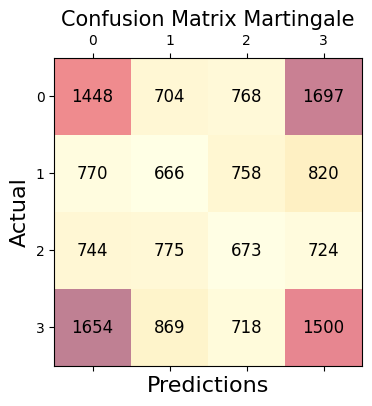

In [22]:
fig, px = plt.subplots(figsize=(4, 4))
px.matshow(confusion_mart, cmap=plt.cm.YlOrRd, alpha=0.5)
for m in range(confusion_mart.shape[0]):
    for n in range(confusion_mart.shape[1]):
        px.text(x=m, y=n, s=confusion_mart[m, n], va='center', ha='center', size='large')

# Sets the labels
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.title('Confusion Matrix Martingale', fontsize=15)
plt.show()

<AxesSubplot:>

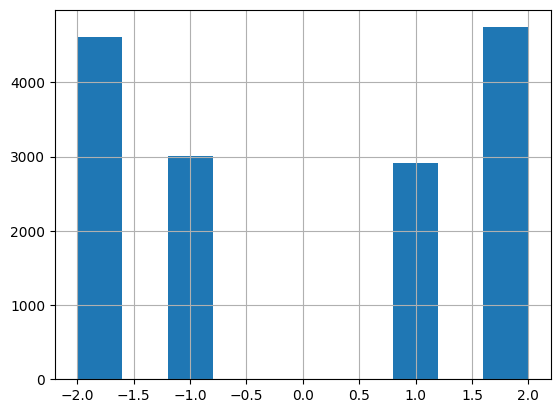

In [26]:
ohlc2['y_hat'].hist()


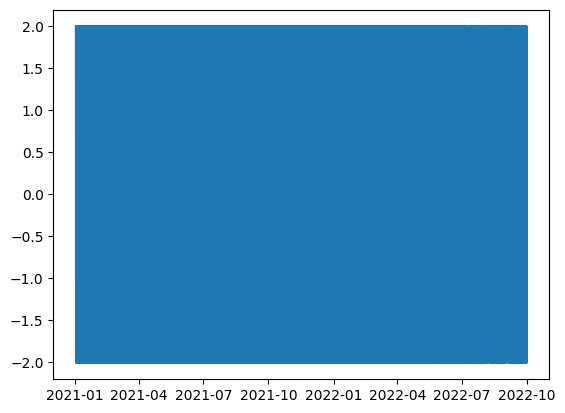

In [30]:
plt.plot(ohlc2['y_hat'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1b0871df0a0>,
 'caps': [<matplotlib.lines.Line2D at 0x1b0871df640>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b0871dedd0>],
 'medians': [<matplotlib.lines.Line2D at 0x1b0871dfbe0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b0871dfeb0>],
 'means': []}

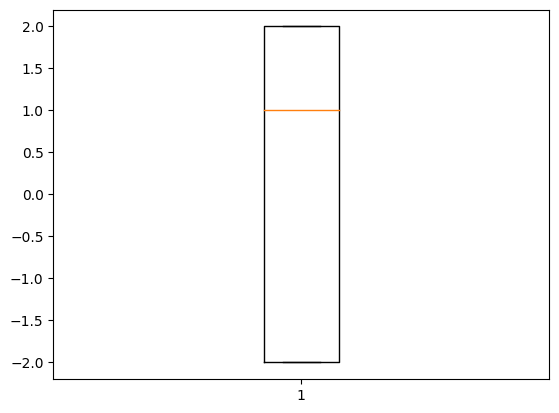

In [35]:
plt.boxplot(ohlc2['y_hat'], notch=None, vert=None, patch_artist=None, widths=None)

# <font color= #6B6B6B> 4.2. Feature Selection and feature transformation   </font>

Then we will apply different normalization and scaling methods to transform the data, then selecting the features to use on the following models, this because is a requirement for models like log regression, and also because we have different scales on the information.

                 open      high       low     close    volume  \
open         1.000000  0.999794  0.999698  0.999625 -0.442783   
high         0.999794  1.000000  0.999546  0.999797 -0.437802   
low          0.999698  0.999546  1.000000  0.999756 -0.450391   
close        0.999625  0.999797  0.999756  1.000000 -0.443530   
volume      -0.442783 -0.437802 -0.450391 -0.443530  1.000000   
...               ...       ...       ...       ...       ...   
lag_vol_24  -0.439940 -0.438568 -0.441401 -0.439839  0.575003   
sum_vol_24  -0.571711 -0.569547 -0.574211 -0.571582  0.746999   
mean_vol_24 -0.571711 -0.569547 -0.574211 -0.571582  0.746999   
y_hat       -0.005430 -0.005170 -0.006063 -0.006297  0.003904   
martingale   0.012725  0.012642  0.014392  0.012747 -0.023644   

             quote_asset_volume    trades  buy_asset_volume  \
open                  -0.105408 -0.392610         -0.445213   
high                  -0.097244 -0.388049         -0.439706   
low                   -0.11788

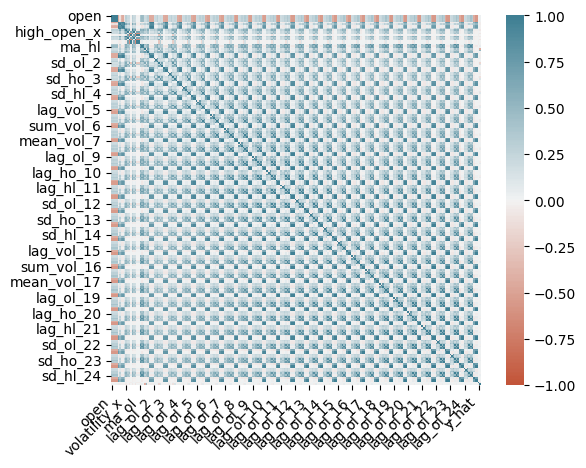

In [36]:
# Heat map
correlation = ohlc2.corr()
print(correlation)

heat = sns.heatmap(
    correlation,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
heat.set_xticklabels(
    heat.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

                 open      high       low     close    volume  \
open         1.000000  0.999698  0.999592  0.999463 -0.427022   
high         0.999698  1.000000  0.999377  0.999706 -0.418730   
low          0.999592  0.999377  1.000000  0.999673 -0.436979   
close        0.999463  0.999706  0.999673  1.000000 -0.427495   
volume      -0.427022 -0.418730 -0.436979 -0.427495  1.000000   
...               ...       ...       ...       ...       ...   
lag_vol_24  -0.424016 -0.420438 -0.427833 -0.423868  0.626495   
sum_vol_24  -0.518048 -0.513037 -0.523656 -0.517859  0.766108   
mean_vol_24 -0.518048 -0.513037 -0.523656 -0.517859  0.766108   
y_hat       -0.007507 -0.007386 -0.008257 -0.008622  0.009701   
martingale   0.014525  0.014487  0.016295  0.014385 -0.022369   

             quote_asset_volume    trades  buy_asset_volume  \
open                  -0.051985 -0.223827         -0.428728   
high                  -0.042881 -0.216144         -0.419856   
low                   -0.06277

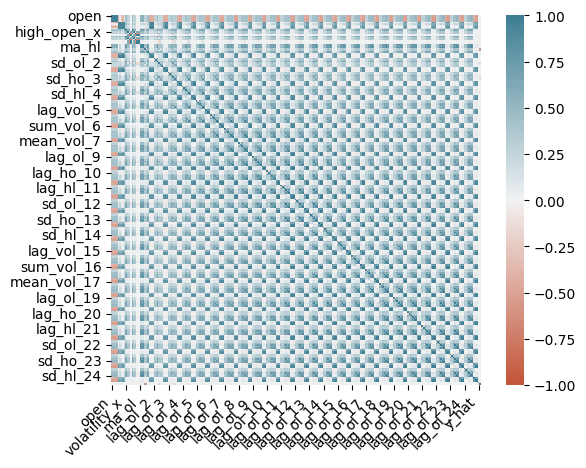

In [38]:
# Heat map spearman
correlation = ohlc2.corr(method='spearman')
print(correlation)

heat = sns.heatmap(
    correlation,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
heat.set_xticklabels(
    heat.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()


                 open      high       low     close    volume  \
open         1.000000  0.987822  0.986822  0.982142 -0.288869   
high         0.987822  1.000000  0.983037  0.988027 -0.282568   
low          0.986822  0.983037  1.000000  0.987658 -0.296357   
close        0.982142  0.988027  0.987658  1.000000 -0.289166   
volume      -0.288869 -0.282568 -0.296357 -0.289166  1.000000   
...               ...       ...       ...       ...       ...   
lag_vol_24  -0.285640 -0.282977 -0.288458 -0.285481  0.452723   
sum_vol_24  -0.356665 -0.352725 -0.361059 -0.356463  0.577962   
mean_vol_24 -0.356665 -0.352725 -0.361059 -0.356463  0.577962   
y_hat       -0.005015 -0.004942 -0.005594 -0.005852  0.007042   
martingale   0.011119  0.011126  0.012404  0.011035 -0.016286   

             quote_asset_volume    trades  buy_asset_volume  \
open                  -0.030580 -0.140393         -0.290345   
high                  -0.024251 -0.134528         -0.283605   
low                   -0.03803

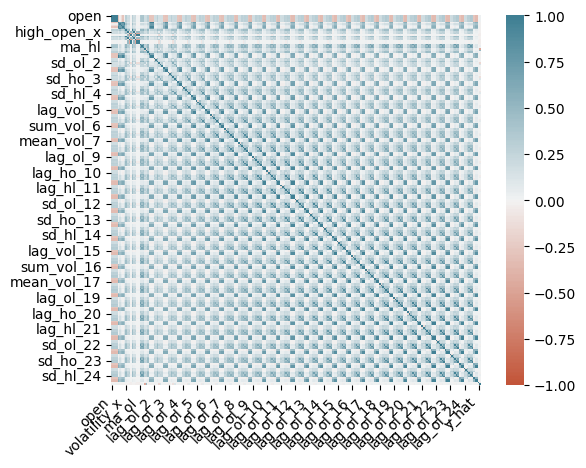

In [39]:
# Heat map kendall
correlation = ohlc2.corr(method='kendall')
print(correlation)

heat = sns.heatmap(
    correlation,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
heat.set_xticklabels(
    heat.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

In [40]:
# %% Separate the datasets
X = ohlc2.iloc[:, :-2]
X.head()
y = ohlc2['y_hat'].copy()
y_true = y.copy()
y.head()

timestamp
2021-01-02 00:00:00    2.0
2021-01-02 01:00:00   -1.0
2021-01-02 02:00:00    1.0
2021-01-02 03:00:00   -1.0
2021-01-02 04:00:00    2.0
Name: y_hat, dtype: float64

In [ ]:
# Genetic Features

In [47]:
# %% Genetic features

# Dictionary
symbolic_params = {'functions': ["sub", "add", 'inv', 'mul', 'div', 'abs', 'log', 'sin'],
                   'population': 10000, 'tournament': 500, 'hof': 50, 'generations': 15, 'n_features': 25,
                   'init_depth': (8, 12), 'init_method': 'half and half', 'parsimony': 0.01, 'constants': None,
                   'metric': 'pearson', 'metric_goal': 0.65,
                   'prob_cross': 0.4, 'prob_mutation_subtree': 0.3,
                   'prob_mutation_hoist': 0.1, 'prob_mutation_point': 0.2,
                   'verbose': True, 'random_cv': None, 'parallelization': True, 'warm_start': True}

In [42]:
# symbolic features
def symbolic_features(p_x, p_y, p_params):
    """
    Feature engineering process with symbolic variables by using genetic programming.
    Parameters
    ----------
    p_x: pd.DataFrame / np.array / list
        with regressors or predictor variables
        p_x = data_features.iloc[:, 1:]
    p_y: pd.DataFrame / np.array / list
        with variable to predict
        p_y = data_features.iloc[:, 0]
    p_params: dict
        with parameters for the genetic programming function
        p_params = {'functions': ["sub", "add", 'inv', 'mul', 'div', 'abs', 'log'],
        'population': 5000, 'tournament':20, 'hof': 20, 'generations': 5, 'n_features':20,
        'init_depth': (4,8), 'init_method': 'half and half', 'parsimony': 0.1, 'constants': None,
        'metric': 'pearson', 'metric_goal': 0.65,
        'prob_cross': 0.4, 'prob_mutation_subtree': 0.3,
        'prob_mutation_hoist': 0.1. 'prob_mutation_point': 0.2,
        'verbose': True, 'random_cv': None, 'parallelization': True, 'warm_start': True }
    Returns
    -------
    results: dict
        With response information
        {'fit': model fitted, 'params': model parameters, 'model': model,
         'data': generated data with variables, 'best_programs': models best programs}
    References
    ----------
    https://gplearn.readthedocs.io/en/stable/reference.html#gplearn.genetic.SymbolicTransformer


    **** NOTE ****
    simplified internal calculation for correlation (asuming w=1)

    y_pred_demean = y_pred - np.average(y_pred)
    y_demean = y - np.average(y)
                              np.sum(y_pred_demean * y_demean)
    pearson =  ---------------------------------------------------------------
                np.sqrt((np.sum(y_pred_demean ** 2) * np.sum(y_demean ** 2)))
    """

    # Function to produce Symbolic Features
    model = SymbolicTransformer(function_set=p_params['functions'], population_size=p_params['population'],
                                tournament_size=p_params['tournament'], hall_of_fame=p_params['hof'],
                                generations=p_params['generations'], n_components=p_params['n_features'],

                                init_depth=p_params['init_depth'], init_method=p_params['init_method'],
                                parsimony_coefficient=p_params['parsimony'],
                                const_range=p_params['constants'],

                                metric=p_params['metric'], stopping_criteria=p_params['metric_goal'],

                                p_crossover=p_params['prob_cross'],
                                p_subtree_mutation=p_params['prob_mutation_subtree'],
                                p_hoist_mutation=p_params['prob_mutation_hoist'],
                                p_point_mutation=p_params['prob_mutation_point'],
                                max_samples=1,

                                verbose=p_params['verbose'], warm_start=p_params['warm_start'],
                                random_state=123, n_jobs=-1 if p_params['parallelization'] else 1,
                                feature_names=p_x.columns)

    # SymbolicTransformer fit
    model_fit = model.fit_transform(p_x, p_y)

    # output data of the model
    data = pd.DataFrame(model_fit)

    # parameters of the model
    model_params = model.get_params()

    # best programs dataframe
    best_programs = {}
    for p in model._best_programs:
        factor_name = 'sym' + str(model._best_programs.index(p))
        best_programs[factor_name] = {'raw_fitness': p.raw_fitness_, 'reg_fitness': p.fitness_,
                                      'expression': str(p), 'depth': p.depth_, 'length': p.length_}

    # format and sorting
    best_programs = pd.DataFrame(best_programs).T
    best_programs = best_programs.sort_values(by='raw_fitness', ascending=False)

    # results
    results = {'fit': model_fit, 'params': model_params, 'model': model, 'data': data,
               'best_programs': best_programs, 'details': model.run_details_}

    return results

In [43]:
def genetic_programed_features(p_data, p_target, p_params):
    """
    El uso de programacion genetica para generar variables independientes simbolicas
    Parameters
    ----------
    p_data: pd.DataFrame
        con datos completos para ajustar modelos

        p_data = m_folds['periodo_1']
    p_split: int
        split in val
        p_split = '0'
    p_params:
        parameters for symbolic_features process
    Returns
    -------
    model_data: dict
        {'train_x': pd.DataFrame, 'train_y': pd.DataFrame, 'val_x': pd.DataFrame, 'val_y': pd.DataFrame}
    References
    ----------
    https://stackoverflow.com/questions/3819977/
    what-are-the-differences-between-genetic-algorithms-and-genetic-programming
    """

    # separacion de variable dependiente
    datos_y = y.copy().astype(int)

    # separacion de variables independientes
    datos_had = X.copy()
    # Lista de operaciones simbolicas
    sym_data = symbolic_features(p_x=datos_had, p_y=datos_y, p_params=symbolic_params)

    # Symbolic variables output
    datos_sym = sym_data['data'].copy()
    datos_sym.columns = ['sym_' + str(i) for i in range(0, len(sym_data['data'].iloc[0, :]))]
    datos_sym.index = datos_y.index

    return {'sym_data': sym_data, 'sym_features': datos_sym}


In [48]:
genetic_prog = genetic_programed_features(p_data=X, p_target=y, p_params=symbolic_params)
# Process description
sym_process = pd.DataFrame(genetic_prog['sym_data']['details'])
sym_features = genetic_prog['sym_features']
print(sym_features)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0   101.89       0.00724543        3         0.053463              N/A      4.87m
   1     3.81        0.0271401        4         0.060781              N/A      2.19m
   2     2.87        0.0284769        3        0.0548907              N/A      1.80m
   3     2.83        0.0286761        3        0.0476028              N/A      1.65m
   4     2.58        0.0284968        3        0.0439453              N/A      1.57m
   5     2.95        0.0286073        4        0.0497673              N/A      1.42m
   6     2.71        0.0286458        2        0.0389787              N/A      1.23m
   7     2.88        0.0283977        4        0.0435502              N/A      1.06m
   8     2.92        0.0282746        3        0.0506683              N/A  

In [52]:
symf= sym_features.T.drop_duplicates().T
symf

sym_0       sym_1     sym_2     sym_3     sym_4  \
timestamp                                                                 
2021-01-02 00:00:00  3.531641  195.975458 -0.662221  1.333268  5.514184   
2021-01-02 01:00:00  5.953685  186.978100  0.363435  1.771779  5.313745   
2021-01-02 02:00:00  4.584253  185.044610 -0.120177  0.350642  3.722111   
2021-01-02 03:00:00  3.675034   29.256858  0.274491  0.187561  2.968339   
2021-01-02 04:00:00  4.204245   47.497370 -0.018591  0.447571  3.827506   
...                       ...         ...       ...       ...       ...   
2022-09-30 19:00:00  4.207078   65.423428 -1.328466  0.594712  4.516180   
2022-09-30 20:00:00  5.280866   65.146187 -0.253086  0.341018  4.010392   
2022-09-30 21:00:00  4.775082   40.380958 -0.591693  0.127440  2.695088   
2022-09-30 22:00:00  4.937778   11.862803  0.358791  0.221278  2.655638   
2022-09-30 23:00:00  4.781893   60.429531  0.754542  1.076147  4.187530   

                      sym_5  
timestamp                    
2021-01-02 00:00:00   34.18  
2021-01-02 01:00:00  385.17  
2021-01-02 02:00:00   97.93  
2021-01-02 03:00:00   39.45  
2021-01-02 04:00:00   66.97  
...                     ...  
2022-09-30 19:00:00   67.16  
2022-09-30 20:00:00  196.54  
2022-09-30 21:00:00  118.52  
2022-09-30 22:00:00  139.46  
2022-09-30 23:00:00  119.33  

[15288 rows x 6 columns]

In [54]:
X2 = pd.merge(X, symf, on='timestamp')
X2

open      high       low     close        volume  \
timestamp                                                                   
2021-01-02 00:00:00  29331.70  29338.59  28946.53  29197.48   2638.159379   
2021-01-02 01:00:00  29197.93  29400.00  29100.00  29359.47   1891.997249   
2021-01-02 02:00:00  29359.46  29469.00  29320.01  29323.82   1704.830137   
2021-01-02 03:00:00  29323.82  29382.49  29256.85  29351.95   1158.041761   
2021-01-02 04:00:00  29351.95  29396.00  29220.00  29349.63    988.711070   
...                       ...       ...       ...       ...           ...   
2022-09-30 19:00:00  19666.83  19768.19  19470.29  19473.52  18501.284980   
2022-09-30 20:00:00  19473.52  19542.72  19355.00  19424.31  18638.811160   
2022-09-30 21:00:00  19424.31  19425.47  19284.85  19361.07   8501.140460   
2022-09-30 22:00:00  19359.77  19400.14  19240.44  19384.86  13559.584800   
2022-09-30 23:00:00  19384.86  19475.40  19358.67  19422.61   9858.755800   

                     quote_asset_volume    trades  buy_asset_volume  \
timestamp                                                             
2021-01-02 00:00:00        7.685653e+07   56787.0       1247.246187   
2021-01-02 01:00:00        5.538540e+07   41136.0        960.492001   
2021-01-02 02:00:00        5.011146e+07   34864.0        919.102507   
2021-01-02 03:00:00        3.396312e+07   33338.0        563.832243   
2021-01-02 04:00:00        2.898578e+07   36593.0        513.998514   
...                                 ...       ...               ...   
2022-09-30 19:00:00        3.636273e+08  274462.0       8643.900630   
2022-09-30 20:00:00        3.623093e+08  289474.0       9152.090890   
2022-09-30 21:00:00        1.646810e+08  148750.0       4056.893540   
2022-09-30 22:00:00        2.621486e+08  179442.0       6621.492300   
2022-09-30 23:00:00        1.914872e+08  124721.0       5059.940130   

                     taker_buy_asset_volume  volatility_x  ...    sd_hl_24  \
timestamp                                                  ...               
2021-01-02 00:00:00            3.633083e+07        392.06  ...  127.559304   
2021-01-02 01:00:00            2.812747e+07        300.00  ...  119.723832   
2021-01-02 02:00:00            2.701882e+07        148.99  ...  122.748351   
2021-01-02 03:00:00            1.653632e+07        125.64  ...  126.344627   
2021-01-02 04:00:00            1.506982e+07        176.00  ...  126.829264   
...                                     ...           ...  ...         ...   
2022-09-30 19:00:00            1.699307e+08        297.90  ...  133.961836   
2022-09-30 20:00:00            1.779168e+08        187.72  ...  133.679411   
2022-09-30 21:00:00            7.859082e+07        140.62  ...  132.588027   
2022-09-30 22:00:00            1.280273e+08        159.70  ...  131.723652   
2022-09-30 23:00:00            9.828441e+07        116.73  ...  133.063548   

                       lag_vol_24     sum_vol_24   mean_vol_24     sym_0  \
timestamp                                                                  
2021-01-02 00:00:00   2311.811445   54509.272945   2271.219706  3.531641   
2021-01-02 01:00:00   5403.068471   50998.201723   2124.925072  5.953685   
2021-01-02 02:00:00   2384.231560   50318.800300   2096.616679  4.584253   
2021-01-02 03:00:00   1461.345077   50015.496984   2083.979041  3.675034   
2021-01-02 04:00:00   2038.046803   48966.161251   2040.256719  4.204245   
...                           ...            ...           ...       ...   
2022-09-30 19:00:00  15817.491090  433631.361130  18067.973380  4.207078   
2022-09-30 20:00:00   9727.755830  442542.416460  18439.267352  5.280866   
2022-09-30 21:00:00   5310.548320  445733.008600  18572.208692  4.775082   
2022-09-30 22:00:00  11951.949720  447340.643680  18639.193487  4.937778   
2022-09-30 23:00:00  12876.446080  444322.953400  18513.456392  4.781893   

                          sym_1     sym_2     sym_3     sym_4   sym_5  
timestamp              

## Transformations

To use the data in the log regression we require to fit the data trought transformations as the data has different scales which would give us a bad forecast.

* The first one is the Normalizer which transforms numeric columns to a standard scale. in this instance it is done by the maximum absolute scaling method which has the following formula:
$$ x_{scaled} =\frac{ x}{max(|x|)} $$

In [57]:
# Normalizer
transformer = Normalizer(norm='max').fit(X)
transformed = transformer.transform(X)
X_normalized = pd.DataFrame(transformed, index=X.index, columns=X.columns)
X_normalized.head()

open      high       low     close    volume  \
timestamp                                                               
2021-01-02 00:00:00  0.000382  0.000382  0.000377  0.000380  0.000034   
2021-01-02 01:00:00  0.000527  0.000531  0.000525  0.000530  0.000034   
2021-01-02 02:00:00  0.000586  0.000588  0.000585  0.000585  0.000034   
2021-01-02 03:00:00  0.000863  0.000865  0.000861  0.000864  0.000034   
2021-01-02 04:00:00  0.001013  0.001014  0.001008  0.001013  0.000034   

                     quote_asset_volume    trades  buy_asset_volume  \
timestamp                                                             
2021-01-02 00:00:00                 1.0  0.000739          0.000016   
2021-01-02 01:00:00                 1.0  0.000743          0.000017   
2021-01-02 02:00:00                 1.0  0.000696          0.000018   
2021-01-02 03:00:00                 1.0  0.000982          0.000017   
2021-01-02 04:00:00                 1.0  0.001262          0.000018   

                     taker_buy_asset_volume  volatility_x  ...  mean_vol_23  \
timestamp                                                  ...                
2021-01-02 00:00:00                0.472710      0.000005  ...     0.000028   
2021-01-02 01:00:00                0.507850      0.000005  ...     0.000038   
2021-01-02 02:00:00                0.539174      0.000003  ...     0.000042   
2021-01-02 03:00:00                0.486891      0.000004  ...     0.000061   
2021-01-02 04:00:00                0.519904      0.000006  ...     0.000071   

                        lag_ol_24  lag_ho_24  lag_hl_24  sd_ol_24  sd_ho_24  \
timestamp                                                                     
2021-01-02 00:00:00  3.037608e-06   0.000001   0.000004  0.000002  0.000001   
2021-01-02 01:00:00  6.279633e-07   0.000009   0.000009  0.000002  0.000002   
2021-01-02 02:00:00  5.786501e-06   0.000001   0.000007  0.000003  0.000002   
2021-01-02 03:00:00  1.331739e-06   0.000005   0.000006  0.000004  0.000003   
2021-01-02 04:00:00  8.590763e-06   0.000004   0.000013  0.000004  0.000003   

                     sd_hl_24  lag_vol_24  sum_vol_24  mean_vol_24  
timestamp                                                           
2021-01-02 00:00:00  0.000002    0.000030    0.000709     0.000030  
2021-01-02 01:00:00  0.000002    0.000098    0.000921     0.000038  
2021-01-02 02:00:00  0.000002    0.000048    0.001004     0.000042  
2021-01-02 03:00:00  0.000004    0.000043    0.001473     0.000061  
2021-01-02 04:00:00  0.000004    0.000070    0.001689     0.000070  

[5 rows x 234 columns]

In [60]:
X_normalized.describe()

open          high           low         close        volume  \
count  15288.000000  15288.000000  15288.000000  15288.000000  15288.000000   
mean       0.000561      0.000563      0.000559      0.000561      0.000028   
std        0.004170      0.004171      0.004170      0.004171      0.000010   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000231      0.000233      0.000229      0.000231      0.000020   
50%        0.000419      0.000421      0.000416      0.000419      0.000025   
75%        0.000699      0.000701      0.000695      0.000699      0.000031   
max        0.485106      0.485106      0.485106      0.485106      0.000056   

       quote_asset_volume        trades  buy_asset_volume  \
count        15288.000000  15288.000000      15288.000000   
mean             0.998823      0.000741          0.000014   
std              0.034294      0.000297          0.000005   
min              0.000000      0.000000          0.000000   
25%              1.000000      0.000548          0.000010   
50%              1.000000      0.000652          0.000012   
75%              1.000000      0.000823          0.000015   
max              1.000000      0.003096          0.000031   

       taker_buy_asset_volume  volatility_x  ...   mean_vol_23     lag_ol_24  \
count            15288.000000  15288.000000  ...  15288.000000  1.528800e+04   
mean                 0.493123      0.000005  ...      0.000084  1.034665e-05   
std                  0.041337      0.000004  ...      0.001423  2.582279e-04   
min                  0.000000      0.000000  ...      0.000002  0.000000e+00   
25%                  0.470987      0.000003  ...      0.000020  6.793298e-07   
50%                  0.494067      0.000004  ...      0.000029  1.717777e-06   
75%                  0.515865      0.000006  ...      0.000044  3.615317e-06   
max                  0.718471      0.000359  ...      0.042624  1.638144e-02   

          lag_ho_24     lag_hl_24      sd_ol_24      sd_ho_24      sd_hl_24  \
count  1.528800e+04  15288.000000  1.528800e+04  1.528800e+04  1.528800e+04   
mean   6.903330e-06      0.000017  8.028845e-06  7.260717e-06  9.023113e-06   
std    1.531416e-04      0.000357  1.628948e-04  1.498722e-04  1.857131e-04   
min    0.000000e+00      0.000000  3.617771e-08  5.680975e-08  6.185883e-08   
25%    6.601492e-07      0.000002  1.192813e-06  1.169719e-06  1.343375e-06   
50%    1.675450e-06      0.000004  2.039005e-06  1.984323e-06  2.295102e-06   
75%    3.537335e-06      0.000007  3.188752e-06  3.067017e-06  3.593415e-06   
max    1.006301e-02      0.017144  5.601856e-03  6.728767e-03  8.195871e-03   

         lag_vol_24    sum_vol_24   mean_vol_24  
count  15288.000000  15288.000000  15288.000000  
mean       0.000089      0.002010      0.000084  
std        0.001791      0.034296      0.001429  
min        0.000000      0.000062      0.000003  
25%        0.000016      0.000479      0.000020  
50%        0.000026      0.000707      0.000029  
75%        0.000043      0.001042      0.000043  
max        0.117431      1.000000      0.041667  

[8 rows x 234 columns]

The second method chosen was Min Max Scaler, which transforms the features by scaling them to a given range in this case 0 to 1.

$$ X_{norm}= \frac{X-X_{min}} {X_{max}-X_{min}} $$

In [58]:
#  Min Max Scaler
scale = MinMaxScaler().fit(X)
X_scale = scale.transform(X)
X_scale = pd.DataFrame(X_scale, index=X.index, columns=X.columns)
X_scale.head()

open      high       low     close    volume  \
timestamp                                                               
2021-01-02 00:00:00  0.427357  0.425197  0.422878  0.425410  0.019228   
2021-01-02 01:00:00  0.425408  0.426087  0.425120  0.427771  0.013789   
2021-01-02 02:00:00  0.427761  0.427087  0.428335  0.427251  0.012425   
2021-01-02 03:00:00  0.427242  0.425833  0.427412  0.427661  0.008440   
2021-01-02 04:00:00  0.427652  0.426029  0.426874  0.427627  0.007206   

                     quote_asset_volume    trades  buy_asset_volume  \
timestamp                                                             
2021-01-02 00:00:00            0.025571  0.054508          0.018178   
2021-01-02 01:00:00            0.018427  0.039485          0.013999   
2021-01-02 02:00:00            0.016673  0.033465          0.013396   
2021-01-02 03:00:00            0.011300  0.032000          0.008218   
2021-01-02 04:00:00            0.009644  0.035125          0.007491   

                     taker_buy_asset_volume  volatility_x  ...  mean_vol_23  \
timestamp                                                  ...                
2021-01-02 00:00:00                0.024173      0.045922  ...     0.064186   
2021-01-02 01:00:00                0.018715      0.035139  ...     0.063313   
2021-01-02 02:00:00                0.017977      0.017451  ...     0.063745   
2021-01-02 03:00:00                0.011002      0.014716  ...     0.062185   
2021-01-02 04:00:00                0.010027      0.020615  ...     0.061332   

                     lag_ol_24  lag_ho_24  lag_hl_24  sd_ol_24  sd_ho_24  \
timestamp                                                                  
2021-01-02 00:00:00   0.028277   0.024854   0.039961  0.062358  0.104838   
2021-01-02 01:00:00   0.004213   0.109578   0.059695  0.061138  0.076748   
2021-01-02 02:00:00   0.035121   0.012751   0.040437  0.060980  0.075304   
2021-01-02 03:00:00   0.005478   0.039632   0.025415  0.060547  0.076098   
2021-01-02 04:00:00   0.030160   0.026903   0.042823  0.059714  0.077885   

                     sd_hl_24  lag_vol_24  sum_vol_24  mean_vol_24  
timestamp                                                           
2021-01-02 00:00:00  0.053120    0.016849    0.070466     0.070466  
2021-01-02 01:00:00  0.049017    0.039379    0.064408     0.064408  
2021-01-02 02:00:00  0.050601    0.017377    0.063236     0.063236  
2021-01-02 03:00:00  0.052484    0.010651    0.062713     0.062713  
2021-01-02 04:00:00  0.052738    0.014854    0.060902     0.060902  

[5 rows x 234 columns]

In [61]:
X_scale.describe()

open          high           low         close        volume  \
count  15288.000000  15288.000000  15288.000000  15288.000000  15288.000000   
mean       0.591504      0.591825      0.589420      0.591505      0.026923   
std        0.182333      0.182186      0.181912      0.182348      0.030129   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.467392      0.468403      0.464265      0.467377      0.010414   
50%        0.592430      0.592451      0.590527      0.592458      0.017359   
75%        0.713661      0.713997      0.711358      0.713676      0.031426   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       quote_asset_volume        trades  buy_asset_volume  \
count        15288.000000  15288.000000      15288.000000   
mean             0.042251      0.086138          0.026624   
std              0.035277      0.074975          0.029957   
min              0.000000      0.000000          0.000000   
25%              0.020413      0.039344          0.010238   
50%              0.033055      0.061157          0.017165   
75%              0.052722      0.102327          0.031039   
max              1.000000      1.000000          1.000000   

       taker_buy_asset_volume  volatility_x  ...   mean_vol_23     lag_ol_24  \
count            15288.000000  15288.000000  ...  15288.000000  15288.000000   
mean                 0.041718      0.057331  ...      0.127249      0.030472   
std                  0.034888      0.046285  ...      0.130125      0.037889   
min                  0.000000      0.000000  ...      0.000000      0.000000   
25%                  0.019904      0.028851  ...      0.051733      0.008862   
50%                  0.032608      0.046140  ...      0.083725      0.019761   
75%                  0.052238      0.072270  ...      0.139331      0.039050   
max                  1.000000      1.000000  ...      1.000000      1.000000   

          lag_ho_24     lag_hl_24      sd_ol_24      sd_ho_24      sd_hl_24  \
count  15288.000000  15288.000000  15288.000000  15288.000000  15288.000000   
mean       0.054927      0.057349      0.114541      0.211615      0.115943   
std        0.060126      0.046275      0.100270      0.132893      0.093118   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.016825      0.028875      0.056370      0.116264      0.062351   
50%        0.036833      0.046146      0.092901      0.188243      0.097578   
75%        0.072166      0.072270      0.140201      0.280351      0.141890   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

         lag_vol_24    sum_vol_24   mean_vol_24  
count  15288.000000  15288.000000  15288.000000  
mean       0.026737      0.128844      0.128844  
std        0.029700      0.131780      0.131780  
min        0.000000      0.000000      0.000000  
25%        0.010411      0.052480      0.052480  
50%        0.017317      0.084846      0.084846  
75%        0.031314      0.140878      0.140878  
max        1.000000      1.000000      1.000000  

[8 rows x 234 columns]

The last one is the standardization method, which removes the mean and sacales to unit variance.

$$ Z=\frac{(X-u)}{S} $$
where:
* U = mean of the training samples 
* S= Standard deviation

In [59]:
# Standardize
scaler = StandardScaler()
scaled = scaler.fit_transform(X)
X_standard = pd.DataFrame(scaled, index=X.index, columns=X.columns)
X_standard.head()

open      high       low     close    volume  \
timestamp                                                               
2021-01-02 00:00:00 -0.900289 -0.914634 -0.915533 -0.910897 -0.255428   
2021-01-02 01:00:00 -0.910979 -0.909749 -0.903208 -0.897954 -0.435934   
2021-01-02 02:00:00 -0.898071 -0.904260 -0.885539 -0.900802 -0.481212   
2021-01-02 03:00:00 -0.900919 -0.911142 -0.890611 -0.898555 -0.613487   
2021-01-02 04:00:00 -0.898671 -0.910067 -0.893571 -0.898740 -0.654450   

                     quote_asset_volume    trades  buy_asset_volume  \
timestamp                                                             
2021-01-02 00:00:00           -0.472845 -0.421889         -0.281938   
2021-01-02 01:00:00           -0.675351 -0.622269         -0.421454   
2021-01-02 02:00:00           -0.725092 -0.702569         -0.441591   
2021-01-02 03:00:00           -0.877396 -0.722106         -0.614442   
2021-01-02 04:00:00           -0.924340 -0.680432         -0.638687   

                     taker_buy_asset_volume  volatility_x  ...  mean_vol_23  \
timestamp                                                  ...                
2021-01-02 00:00:00               -0.502905     -0.246515  ...    -0.484650   
2021-01-02 01:00:00               -0.659354     -0.479491  ...    -0.491357   
2021-01-02 02:00:00               -0.680497     -0.861650  ...    -0.488039   
2021-01-02 03:00:00               -0.880412     -0.920741  ...    -0.500030   
2021-01-02 04:00:00               -0.908380     -0.793296  ...    -0.506587   

                     lag_ol_24  lag_ho_24  lag_hl_24  sd_ol_24  sd_ho_24  \
timestamp                                                                  
2021-01-02 00:00:00  -0.057932  -0.500176  -0.375759 -0.520446 -0.803505   
2021-01-02 01:00:00  -0.693066   0.908956   0.050709 -0.532615 -1.014884   
2021-01-02 02:00:00   0.122717  -0.701475  -0.365482 -0.534194 -1.025748   
2021-01-02 03:00:00  -0.659660  -0.254395  -0.690117 -0.538504 -1.019774   
2021-01-02 04:00:00  -0.008223  -0.466095  -0.313920 -0.546811 -1.006332   

                     sd_hl_24  lag_vol_24  sum_vol_24  mean_vol_24  
timestamp                                                           
2021-01-02 00:00:00 -0.674678   -0.332936   -0.443008    -0.443008  
2021-01-02 01:00:00 -0.718747    0.425663   -0.488979    -0.488979  
2021-01-02 02:00:00 -0.701736   -0.315164   -0.497875    -0.497875  
2021-01-02 03:00:00 -0.681510   -0.541641   -0.501846    -0.501846  
2021-01-02 04:00:00 -0.678784   -0.400118   -0.515585    -0.515585  

[5 rows x 234 columns]

In [62]:
X_standard.describe()

open          high           low         close        volume  \
count  1.528800e+04  1.528800e+04  1.528800e+04  15288.000000  1.528800e+04   
mean   2.379630e-16  8.923614e-16 -1.784723e-16      0.000000 -1.487269e-16   
std    1.000033e+00  1.000033e+00  1.000033e+00      1.000033  1.000033e+00   
min   -3.244189e+00 -3.248569e+00 -3.240239e+00     -3.243930 -8.936312e-01   
25%   -6.807137e-01 -6.774745e-01 -6.880179e-01     -0.680744 -5.479742e-01   
50%    5.075071e-03  3.436352e-03  6.090488e-03      0.005227 -3.174559e-01   
75%    6.699876e-01  6.706069e-01  6.703379e-01      0.670009  1.494568e-01   
max    2.240452e+00  2.240500e+00  2.257100e+00      2.240263  3.229848e+01   

       quote_asset_volume        trades  buy_asset_volume  \
count        1.528800e+04  1.528800e+04      1.528800e+04   
mean        -1.784723e-16  1.487269e-17     -2.974538e-17   
std          1.000033e+00  1.000033e+00      1.000033e+00   
min         -1.197720e+00 -1.148931e+00     -8.887644e-01   
25%         -6.190510e-01 -6.241506e-01     -5.469983e-01   
50%         -2.606753e-01 -3.332032e-01     -3.157533e-01   
75%          2.968339e-01  2.159288e-01      1.473609e-01   
max          2.715004e+01  1.218928e+01      3.249296e+01   

       taker_buy_asset_volume  volatility_x  ...   mean_vol_23     lag_ol_24  \
count            1.528800e+04  1.528800e+04  ...  15288.000000  1.528800e+04   
mean            -8.923614e-17  2.974538e-17  ...      0.000000 -5.949076e-17   
std              1.000033e+00  1.000033e+00  ...      1.000033  1.000033e+00   
min             -1.195781e+00 -1.238697e+00  ...     -0.977933 -8.042495e-01   
25%             -6.252564e-01 -6.153506e-01  ...     -0.580356 -5.703501e-01   
50%             -2.611125e-01 -2.417957e-01  ...     -0.334490 -2.826811e-01   
75%              3.015663e-01  3.227691e-01  ...      0.092853  2.264039e-01   
max              2.746791e+01  2.036718e+01  ...      6.707261  2.558924e+01   

          lag_ho_24     lag_hl_24      sd_ol_24      sd_ho_24      sd_hl_24  \
count  1.528800e+04  1.528800e+04  1.528800e+04  1.528800e+04  1.528800e+04   
mean   1.487269e-17 -1.189815e-16 -1.487269e-16  8.923614e-17 -2.082177e-16   
std    1.000033e+00  1.000033e+00  1.000033e+00  1.000033e+00  1.000033e+00   
min   -9.135588e-01 -1.239351e+00 -1.142368e+00 -1.592422e+00 -1.245156e+00   
25%   -6.337166e-01 -6.153368e-01 -5.801639e-01 -7.175204e-01 -5.755476e-01   
50%   -3.009494e-01 -2.420951e-01 -2.158310e-01 -1.758754e-01 -1.972301e-01   
75%    2.867231e-01  3.224725e-01  2.559146e-01  5.172472e-01  2.786579e-01   
max    1.571862e+01  2.037147e+01  8.831049e+00  5.932676e+00  9.494228e+00   

         lag_vol_24    sum_vol_24   mean_vol_24  
count  1.528800e+04  1.528800e+04  1.528800e+04  
mean  -5.949076e-17 -1.338542e-16 -1.041088e-16  
std    1.000033e+00  1.000033e+00  1.000033e+00  
min   -9.002575e-01 -9.777525e-01 -9.777525e-01  
25%   -5.496997e-01 -5.794994e-01 -5.794994e-01  
50%   -3.171714e-01 -3.338856e-01 -3.338856e-01  
75%    1.541184e-01  9.132008e-02  9.132008e-02  
max    3.277058e+01  6.610904e+00  6.610904e+00  

[8 rows x 234 columns]

                 open      high       low     close    volume  \
open         1.000000  1.000000  1.000000  1.000000 -0.057343   
high         1.000000  1.000000  1.000000  1.000000 -0.057478   
low          1.000000  1.000000  1.000000  1.000000 -0.057198   
close        1.000000  1.000000  1.000000  1.000000 -0.057342   
volume      -0.057343 -0.057478 -0.057198 -0.057342  1.000000   
...               ...       ...       ...       ...       ...   
sd_ho_24     0.118154  0.118142  0.118170  0.118158 -0.090988   
sd_hl_24     0.197941  0.197909  0.197964  0.197931 -0.093346   
lag_vol_24   0.146801  0.146771  0.146824  0.146793 -0.074963   
sum_vol_24   0.230360  0.230319  0.230388  0.230345 -0.083307   
mean_vol_24  0.230360  0.230319  0.230388  0.230345 -0.083307   

             quote_asset_volume    trades  buy_asset_volume  \
open                  -0.217271 -0.013297         -0.054062   
high                  -0.217213 -0.013363         -0.054161   
low                   -0.21730

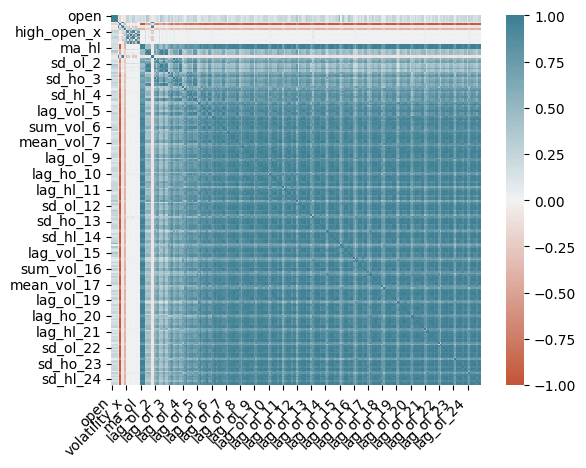

In [63]:
# %% Heatmaps
# Heat map
correlation = X_normalized.corr()
print(correlation)

heat = sns.heatmap(
    correlation,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
heat.set_xticklabels(
    heat.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

In [64]:
corr = correlation[correlation >= .80]
corr2 = corr.corr(method='spearman')
print(corr2)

             open  high  low  close  volume  quote_asset_volume  trades  \
open          1.0  -0.6  0.6   -1.0     NaN                 NaN     NaN   
high         -0.6   1.0 -1.0    0.6     NaN                 NaN     NaN   
low           0.6  -1.0  1.0   -0.6     NaN                 NaN     NaN   
close        -1.0   0.6 -0.6    1.0     NaN                 NaN     NaN   
volume        NaN   NaN  NaN    NaN     1.0                 NaN     NaN   
...           ...   ...  ...    ...     ...                 ...     ...   
sd_ho_24      NaN   NaN  NaN    NaN     NaN                 NaN     NaN   
sd_hl_24      NaN   NaN  NaN    NaN     NaN                 NaN     NaN   
lag_vol_24    NaN   NaN  NaN    NaN     NaN                 NaN     NaN   
sum_vol_24    NaN   NaN  NaN    NaN     NaN                 NaN     NaN   
mean_vol_24   NaN   NaN  NaN    NaN     NaN                 NaN     NaN   

             buy_asset_volume  taker_buy_asset_volume  volatility_x  ...  \
open                   

<AxesSubplot:>

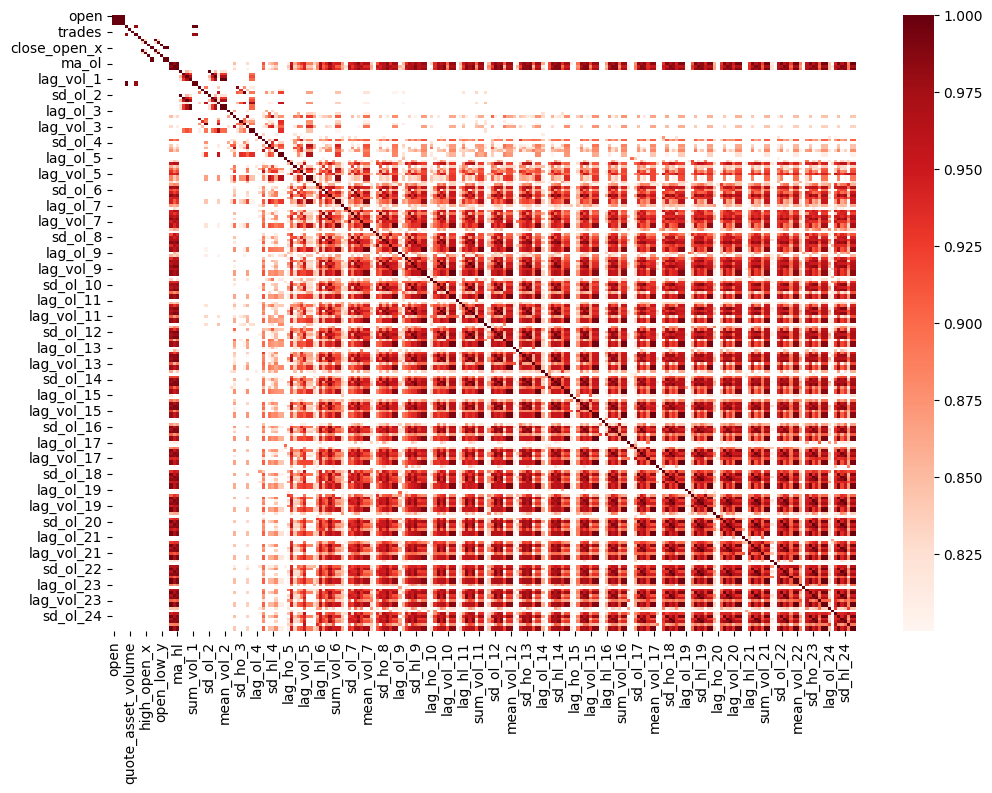

In [65]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap="Reds")


             open  high  low  close  volume  quote_asset_volume  trades  \
open          1.0  -0.6  0.6   -1.0     NaN                 NaN     NaN   
high         -0.6   1.0 -1.0    0.6     NaN                 NaN     NaN   
low           0.6  -1.0  1.0   -0.6     NaN                 NaN     NaN   
close        -1.0   0.6 -0.6    1.0     NaN                 NaN     NaN   
volume        NaN   NaN  NaN    NaN     1.0                 NaN     NaN   
...           ...   ...  ...    ...     ...                 ...     ...   
sd_ho_24      NaN   NaN  NaN    NaN     NaN                 NaN     NaN   
sd_hl_24      NaN   NaN  NaN    NaN     NaN                 NaN     NaN   
lag_vol_24    NaN   NaN  NaN    NaN     NaN                 NaN     NaN   
sum_vol_24    NaN   NaN  NaN    NaN     NaN                 NaN     NaN   
mean_vol_24   NaN   NaN  NaN    NaN     NaN                 NaN     NaN   

             buy_asset_volume  taker_buy_asset_volume  volatility_x  ...  \
open                   

<AxesSubplot:>

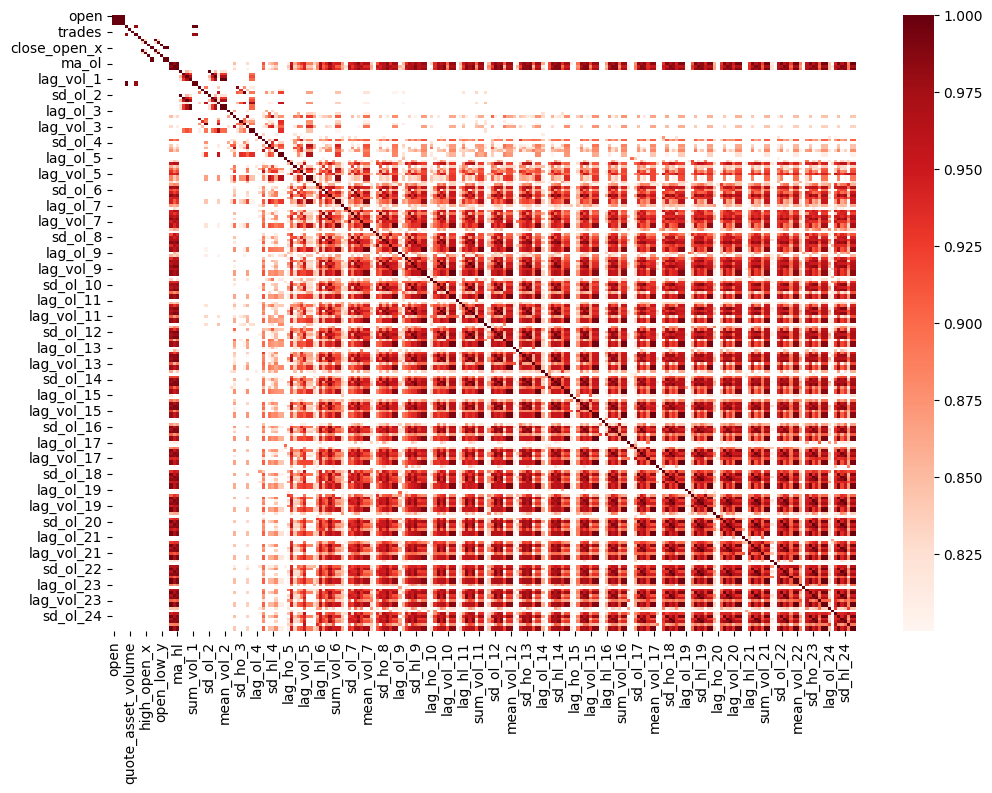

In [66]:
corr = correlation[correlation >= .80]
corr2 = corr.corr(method='spearman')
print(corr2)
plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap="Reds")


In [67]:
cor_matrix = X_normalized.corr().abs()
print(cor_matrix)


                 open      high       low     close    volume  \
open         1.000000  1.000000  1.000000  1.000000  0.057343   
high         1.000000  1.000000  1.000000  1.000000  0.057478   
low          1.000000  1.000000  1.000000  1.000000  0.057198   
close        1.000000  1.000000  1.000000  1.000000  0.057342   
volume       0.057343  0.057478  0.057198  0.057342  1.000000   
...               ...       ...       ...       ...       ...   
sd_ho_24     0.118154  0.118142  0.118170  0.118158  0.090988   
sd_hl_24     0.197941  0.197909  0.197964  0.197931  0.093346   
lag_vol_24   0.146801  0.146771  0.146824  0.146793  0.074963   
sum_vol_24   0.230360  0.230319  0.230388  0.230345  0.083307   
mean_vol_24  0.230360  0.230319  0.230388  0.230345  0.083307   

             quote_asset_volume    trades  buy_asset_volume  \
open                   0.217271  0.013297          0.054062   
high                   0.217213  0.013363          0.054161   
low                    0.21730

In [68]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
print(upper_tri)

             open  high  low  close    volume  quote_asset_volume    trades  \
open          NaN   1.0  1.0    1.0  0.057343            0.217271  0.013297   
high          NaN   NaN  1.0    1.0  0.057478            0.217213  0.013363   
low           NaN   NaN  NaN    1.0  0.057198            0.217305  0.013222   
close         NaN   NaN  NaN    NaN  0.057342            0.217244  0.013294   
volume        NaN   NaN  NaN    NaN       NaN            0.091572  0.576899   
...           ...   ...  ...    ...       ...                 ...       ...   
sd_ho_24      NaN   NaN  NaN    NaN       NaN                 NaN       NaN   
sd_hl_24      NaN   NaN  NaN    NaN       NaN                 NaN       NaN   
lag_vol_24    NaN   NaN  NaN    NaN       NaN                 NaN       NaN   
sum_vol_24    NaN   NaN  NaN    NaN       NaN                 NaN       NaN   
mean_vol_24   NaN   NaN  NaN    NaN       NaN                 NaN       NaN   

             buy_asset_volume  taker_buy_asset_volu

C:\Users\Emilio\AppData\Local\Temp\ipykernel_10004\12419535.py:1: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [75]:
# .5 according to JF, but not many features after that.
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= .85)]
print();
print(to_drop)


['high', 'low', 'close', 'buy_asset_volume', 'volatility_y', 'high_open_y', 'open_low_y', 'close_open_y', 'co', 'ma_ol', 'ma_ho', 'ma_hl', 'lag_hl_1', 'lag_vol_1', 'sum_vol_1', 'mean_vol_1', 'lag_hl_2', 'sd_ol_2', 'sd_ho_2', 'sd_hl_2', 'lag_vol_2', 'sum_vol_2', 'mean_vol_2', 'lag_hl_3', 'sd_ol_3', 'sd_ho_3', 'sd_hl_3', 'lag_vol_3', 'sum_vol_3', 'mean_vol_3', 'lag_hl_4', 'sd_ol_4', 'sd_ho_4', 'sd_hl_4', 'lag_vol_4', 'sum_vol_4', 'mean_vol_4', 'lag_hl_5', 'sd_ol_5', 'sd_ho_5', 'sd_hl_5', 'lag_vol_5', 'sum_vol_5', 'mean_vol_5', 'lag_ol_6', 'lag_ho_6', 'lag_hl_6', 'sd_ol_6', 'sd_ho_6', 'sd_hl_6', 'lag_vol_6', 'sum_vol_6', 'mean_vol_6', 'lag_ol_7', 'lag_hl_7', 'sd_ol_7', 'sd_ho_7', 'sd_hl_7', 'lag_vol_7', 'sum_vol_7', 'mean_vol_7', 'lag_ol_8', 'lag_hl_8', 'sd_ol_8', 'sd_ho_8', 'sd_hl_8', 'lag_vol_8', 'sum_vol_8', 'mean_vol_8', 'lag_ol_9', 'lag_ho_9', 'lag_hl_9', 'sd_ol_9', 'sd_ho_9', 'sd_hl_9', 'lag_vol_9', 'sum_vol_9', 'mean_vol_9', 'lag_ho_10', 'lag_hl_10', 'sd_ol_10', 'sd_ho_10', 'sd_hl

In [76]:
# Choose transformation
# x = X_standard.copy()
x = X_scale.copy()
# x = X_normalized.copy()
# x = X.copy()

# Drop highly correlated
x = x.drop(x[to_drop], axis=1)
print();
print(x.head())
x.head()


                         open    volume  quote_asset_volume    trades  \
timestamp                                                               
2021-01-02 00:00:00  0.427357  0.019228            0.025571  0.054508   
2021-01-02 01:00:00  0.425408  0.013789            0.018427  0.039485   
2021-01-02 02:00:00  0.427761  0.012425            0.016673  0.033465   
2021-01-02 03:00:00  0.427242  0.008440            0.011300  0.032000   
2021-01-02 04:00:00  0.427652  0.007206            0.009644  0.035125   

                     taker_buy_asset_volume  volatility_x  high_open_x  \
timestamp                                                                
2021-01-02 00:00:00                0.024173      0.045922     0.001590   
2021-01-02 01:00:00                0.018715      0.035139     0.046628   
2021-01-02 02:00:00                0.017977      0.017451     0.025277   
2021-01-02 03:00:00                0.011002      0.014716     0.013538   
2021-01-02 04:00:00                0.010027

open    volume  quote_asset_volume    trades  \
timestamp                                                               
2021-01-02 00:00:00  0.427357  0.019228            0.025571  0.054508   
2021-01-02 01:00:00  0.425408  0.013789            0.018427  0.039485   
2021-01-02 02:00:00  0.427761  0.012425            0.016673  0.033465   
2021-01-02 03:00:00  0.427242  0.008440            0.011300  0.032000   
2021-01-02 04:00:00  0.427652  0.007206            0.009644  0.035125   

                     taker_buy_asset_volume  volatility_x  high_open_x  \
timestamp                                                                
2021-01-02 00:00:00                0.024173      0.045922     0.001590   
2021-01-02 01:00:00                0.018715      0.035139     0.046628   
2021-01-02 02:00:00                0.017977      0.017451     0.025277   
2021-01-02 03:00:00                0.011002      0.014716     0.013538   
2021-01-02 04:00:00                0.010027      0.020615     0.010165   

                     open_low_x  close_open_x  lag_ol_1  ...  lag_ol_10  \
timestamp                                                ...              
2021-01-02 00:00:00    0.046652      0.470853  0.004140  ...   0.024059   
2021-01-02 01:00:00    0.011861      0.508949  0.046652  ...   0.036056   
2021-01-02 02:00:00    0.004778      0.483551  0.011861  ...   0.007712   
2021-01-02 03:00:00    0.008111      0.491765  0.004778  ...   0.044062   
2021-01-02 04:00:00    0.015982      0.487843  0.008111  ...   0.054870   

                     lag_ol_11  lag_ho_14  lag_ol_15  lag_ho_15  lag_ol_16  \
timestamp                                                                    
2021-01-02 00:00:00   0.004056   0.032942   0.003635   0.071007   0.026719   
2021-01-02 01:00:00   0.024059   0.041247   0.005975   0.032942   0.003635   
2021-01-02 02:00:00   0.036056   0.066113   0.001378   0.041247   0.005975   
2021-01-02 03:00:00   0.007712   0.054575   0.019802   0.066113   0.001378   
2021-01-02 04:00:00   0.044062   0.015047   0.004056   0.054575   0.019802   

                     lag_ho_16  lag_ho_20  lag_ho_21  lag_ho_22  
timestamp                                                        
2021-01-02 00:00:00   0.019658   0.026903   0.039632   0.012751  
2021-01-02 01:00:00   0.071007   0.003454   0.026903   0.039632  
2021-01-02 02:00:00   0.032942   0.019150   0.003454   0.026903  
2021-01-02 03:00:00   0.041247   0.004068   0.019150   0.003454  
2021-01-02 04:00:00   0.066113   0.019658   0.004068   0.019150  

[5 rows x 31 columns]

Next we split the dataset, as this is a timeseries we require to split it without changing the timeline or it would influence the forecasting.

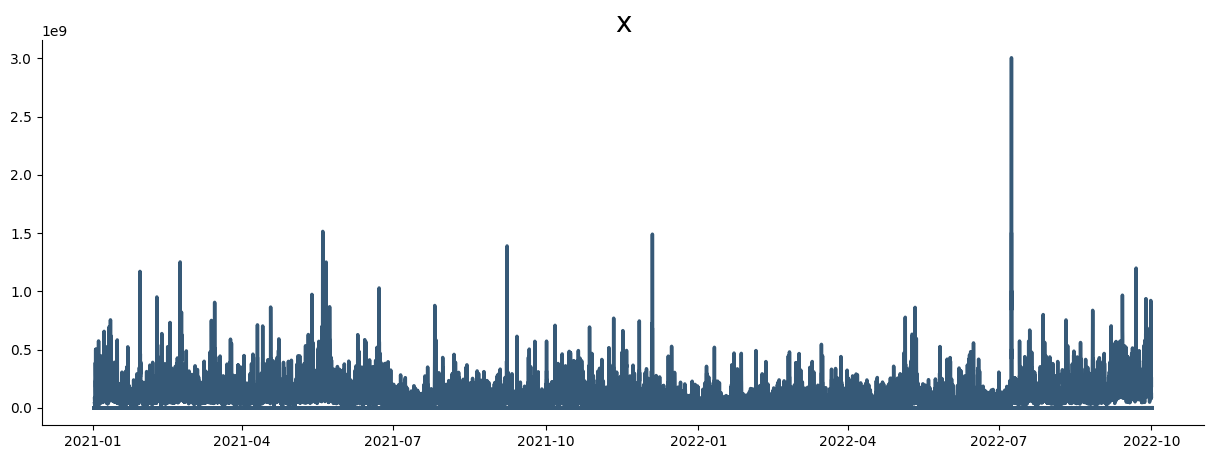

In [77]:
rcParams['figure.figsize'] = 15, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.prop_cycle'] = cycler(color=['#365977'])
rcParams['lines.linewidth'] = 2.5
plt.title('x', size=20)
plt.plot(X)

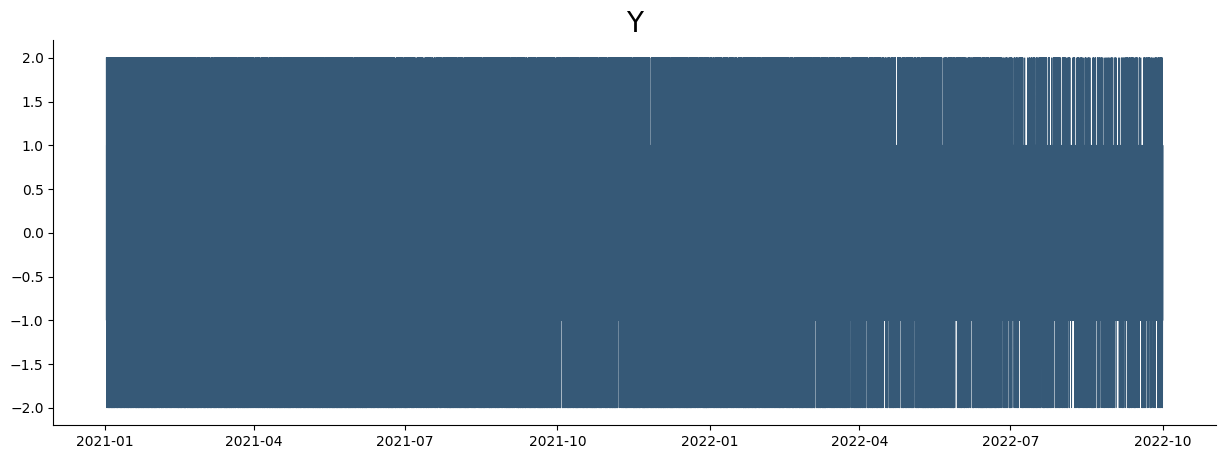

In [78]:
rcParams['figure.figsize'] = 15, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.prop_cycle'] = cycler(color=['#365977'])
rcParams['lines.linewidth'] = .5
plt.title('Y', size=20)
plt.plot(y)

In [79]:
test_size = int(len(x) * .20)
X_train = x[:-test_size].copy()
X_test = x[-test_size:].copy()
X_train2 = x[:-test_size].copy()
X_test2 = x[-test_size:].copy()
X_train3 = x[:-test_size].copy()
X_test3 = x[-test_size:].copy()


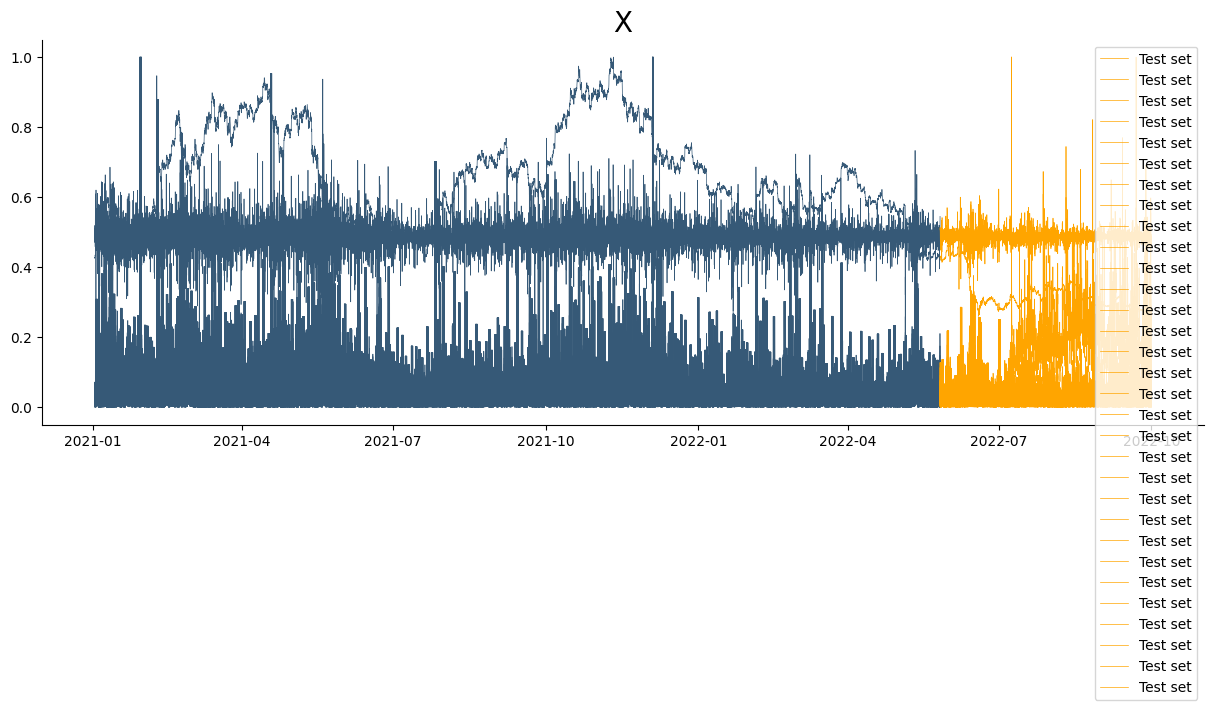

In [80]:
plt.title('X', size=20)
plt.plot(X_train)  # ,label='Training set')
plt.plot(X_test, label='Test set', color='orange')
plt.legend(loc='upper right');


In [81]:
y_train = y[:-test_size].copy()
y_test = y[-test_size:].copy()
y_train2 = y[:-test_size].copy()
y_test2 = y[-test_size:].copy()
y_train3 = y[:-test_size].copy()
y_test3 = y[-test_size:].copy()
X_train4 = X_train.copy()
y_train4 = y_train.copy()
X_test4 = X_test.copy()
y_test4 = y_test.copy()
Y_train_dum = pd.get_dummies(y_train4, prefix='y')
Y_test_dum = pd.get_dummies(y_test4, prefix='y')
# one hot encoder is better.

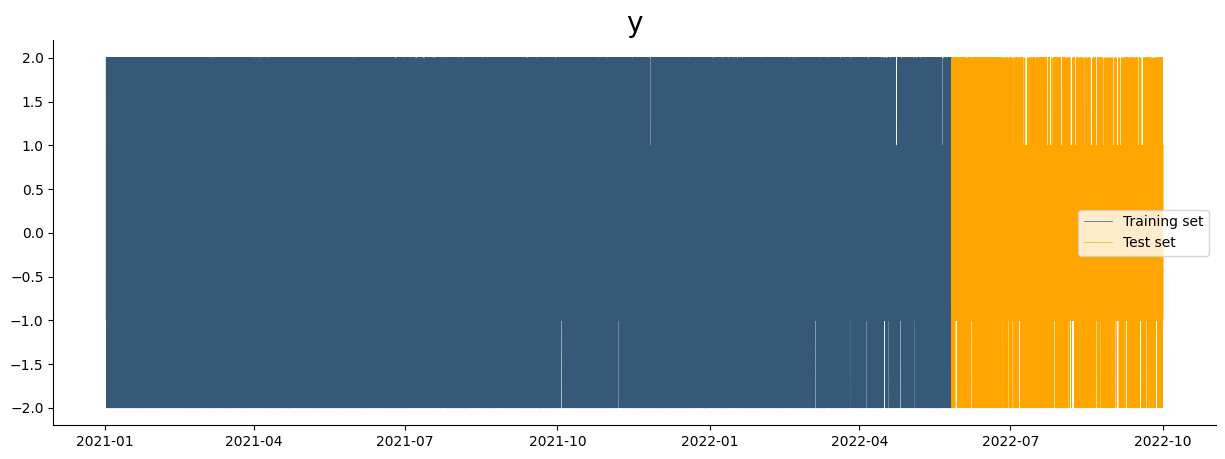

In [82]:
plt.title('y', size=20)
plt.plot(y_train, label='Training set')
plt.plot(y_test, label='Test set', color='orange')
plt.legend();


## Naive Bayes

In [88]:
# %% Naive Bayes
print(X_train.shape, X_test.shape)
# instantiate the model
gnb = GaussianNB()
# gnb = CategoricalNB()
# pgmpy()

# fit the model
gnb.fit(X_train2, y_train2)

(12231, 31) (3057, 31)


GaussianNB()

In [89]:
y_pred2 = gnb.predict(X_test2)

In [90]:
accuracy_naive = (accuracy_score(y_test2, y_pred2)) * 100
recall_naive = recall_score(y_test2, y_pred2, average='weighted') * 100
precision_naive = precision_score(y_test2, y_pred2, average='weighted', zero_division=0) * 100
f1_naive = f1_score(y_test2, y_pred2, average='weighted') * 100
balanced_naive = balanced_accuracy_score(y_test2, y_pred2) * 100
print('Accuracy:', accuracy_naive, '%')
print('Recall:', recall_naive, '%')
print('Precision:', precision_naive, '%')
print('F1:', f1_naive, '%')
print('Balanced Accuracy:', balanced_naive, '%')

Accuracy: 27.706902191691203 %
Recall: 27.706902191691203 %
Precision: 32.05149251566784 %
F1: 25.704615640939565 %
Balanced Accuracy: 26.369913009695818 %


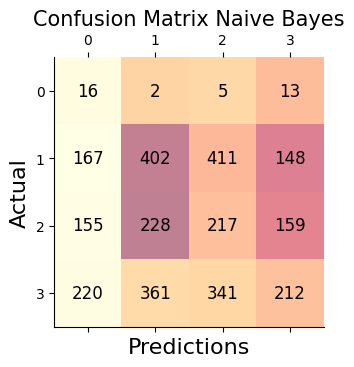

In [87]:
y_pred_train = gnb.predict(X_train2)
conf_mat = confusion_matrix(y_test2, y_pred2)
fig, px = plt.subplots(figsize=(3.5, 3.5))
px.matshow(conf_mat, cmap=plt.cm.YlOrRd, alpha=0.5)
for m in range(conf_mat.shape[0]):
    for n in range(conf_mat.shape[1]):
        px.text(x=m, y=n, s=conf_mat[m, n], va='center', ha='center', size='large')
# Sets the labels
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.title('Confusion Matrix Naive Bayes', fontsize=15)
plt.show()

The logistic Regression was chosen because of the type of target variable which is  categorical feature. 
* The cost function in this case is the following one:
$$ \underset{w,c}{min}\frac{1-p}{2}{w}^{T}w+\rho||w||_1+C\sum_{i=1}^{n}log(exp(-y_i(\mathrm{X}_{i}^{T}w+c))+1) $$

This cost function is the one used for Elastic Net regularization, which is a combination of the L1 and L2 penalizations.

In [91]:
# model fit
logistic_model = LogisticRegression(random_state=False, penalty='elasticnet',
                                    solver='saga', l1_ratio=.56, max_iter=1000000, C=1,
                                    class_weight='balanced', )
logistic_model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced', l1_ratio=0.56,
                   max_iter=1000000, penalty='elasticnet', random_state=False,
                   solver='saga')

In [92]:
# logistic_model.predict_proba((X[:2, :])
y_pred = logistic_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) * 100
logistic_model.score(x, y)
confusion_mat = confusion_matrix(y_test, y_pred)
print(accuracy)


34.380111220150475


In [93]:
logistic_model.get_params(deep=True)

{'C': 1,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': 0.56,
 'max_iter': 1000000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'elasticnet',
 'random_state': False,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [94]:
# si fueron 0 se quitaron por efecto de la regularizacion L1 y son:
# si
coef = logistic_model.coef_
print(logistic_model.intercept_)
print(coef)

[-0.89132945 -0.75761303  0.56461832  1.08432416]
[[ 0.37847549  0.          0.          0.50632694  0.13090208  1.04000042
   0.          0.79747719  0.11528722  0.24110939  0.90061788  0.13857534
   0.68019988  0.25432013  0.68162685  0.84925018  0.15736146  0.64357669
   0.16231475  0.33932221  0.          0.          0.43156393  0.40756973
   0.32948616  0.12923422  0.12213493  0.50812473  0.          0.38467607
   0.4260773 ]
 [-0.11608638  0.          0.         -0.21989222  0.         -0.83381232
  -1.09249382  0.          2.74696002 -1.91211955  0.12350118 -3.1618926
  -0.14503586  0.          0.         -1.60069674 -0.42610634 -0.49063314
  -0.17325829 -0.18081252 -0.15720834  0.         -0.56084552 -0.25481958
  -0.05764817 -0.02046002 -0.5511267  -0.68339649 -0.41064712 -0.50631165
  -0.54298448]
 [-0.10299017  0.         -0.44997067 -0.50561672 -0.19651797 -1.02935602
  -0.961282    0.          0.          0.         -0.54642074  0.
  -0.71512722 -2.14465309 -0.84499699 -0.

In [95]:
predict_ = logistic_model.predict_proba(X_train)
print(predict_)

[[0.17031107 0.3271119  0.33160823 0.1709688 ]
 [0.1729526  0.32879846 0.32026841 0.17798053]
 [0.16337027 0.3092805  0.34854727 0.17880196]
 ...
 [0.19052896 0.28823889 0.3194745  0.20175764]
 [0.2270331  0.28538838 0.28683787 0.20074064]
 [0.19841699 0.28279258 0.27358658 0.24520385]]


(1.0, 30000.0, -3.0, 3.0)

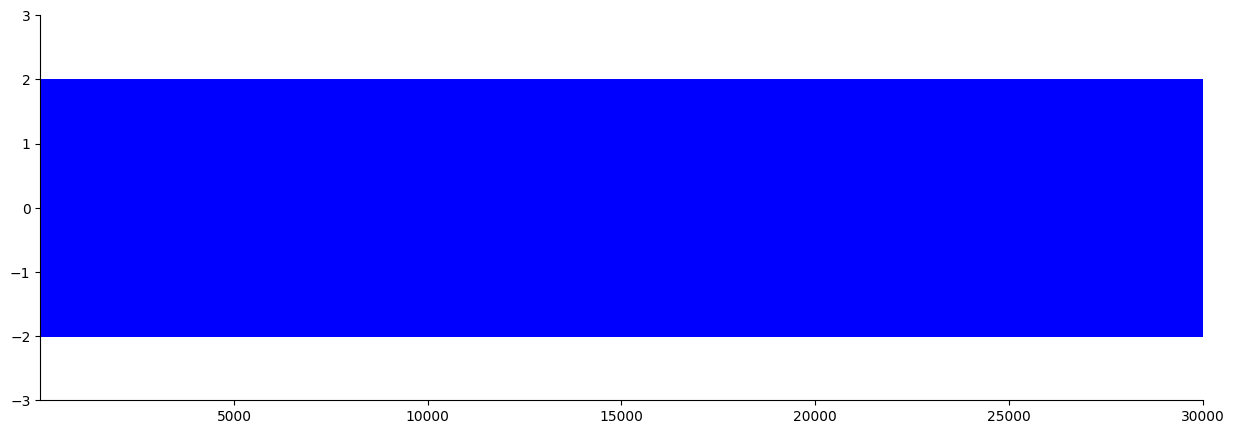

In [96]:
# ver como funciona con cada clase, resultados no son fuertes,
# 1) analisis de los coeficientes por efectos de la regularizacion ( estos se quitaron , estos se redujeron)
# 2) analisis probabilistico para cada clase.

plt.plot(X_test, y_pred, 'r')
plt.plot(X, y_true, 'b')
plt.axis([1, 30000, -3, 3])


In [97]:
# logistic_model.predict_proba((X[:2, :])
y_pred = logistic_model.predict(X_test)
accuracy_logistic = accuracy_score(y_test, y_pred) * 100
logistic_model.score(x, y)
confusion_mat = confusion_matrix(y_test, y_pred)

In [98]:
recall_logistic = recall_score(y_test, y_pred, average='weighted') * 100
precision_logistic = precision_score(y_test, y_pred, average='weighted', zero_division=0) * 100
f1_logistic = f1_score(y_test, y_pred, average='weighted') * 100
balanced_logistic = balanced_accuracy_score(y_test, y_pred) * 100

print('Accuracy:', accuracy_logistic, '%')
print('Recall:', recall_logistic, '%')
print('Precision:', precision_logistic, '%')
print('F1:', f1_logistic, '%')
print('Balanced Accuracy:', balanced_logistic, '%')
print("Confusion Matrix:")

print(confusion_mat)


Accuracy: 34.380111220150475 %
Recall: 34.380111220150475 %
Precision: 34.34422440997515 %
F1: 25.532176982127336 %
Balanced Accuracy: 27.164308915964174 %
Confusion Matrix:
[[ 10 396 116  36]
 [  1 832 149  11]
 [  2 773 190   9]
 [  9 367 137  19]]


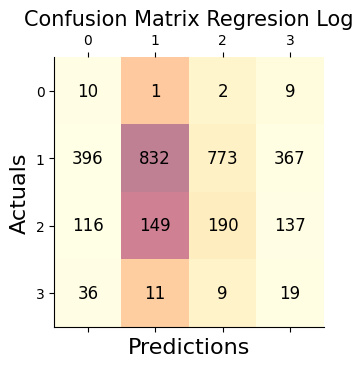

In [99]:
fig, px = plt.subplots(figsize=(3.5, 3.5))
px.matshow(confusion_mat, cmap=plt.cm.YlOrRd, alpha=0.5)
for m in range(confusion_mat.shape[0]):
    for n in range(confusion_mat.shape[1]):
        px.text(x=m, y=n, s=confusion_mat[m, n], va='center', ha='center', size='large')

# Sets the labels
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix Regresion Log', fontsize=15)
plt.show()

## Random Forest

In [100]:
# Create a Random forest Classifier
clf = RandomForestClassifier(n_estimators=1000, max_depth=None,
                             max_features=None, min_samples_split=2,
                             oob_score=True,n_jobs=4)

# Train the model using the training sets
clf.fit(X_train3, y_train3)

# performing predictions on the test dataset
y_pred = clf.predict(X_test3)
accuracy_forest = accuracy_score(y_test3, y_pred) * 100
print(clf.score(x, y))

0.8658424908424909


In [101]:
confusion_mat = confusion_matrix(y_test3, y_pred)

In [102]:
recall_forest = recall_score(y_test3, y_pred, average='weighted') * 100
precision_forest = precision_score(y_test3, y_pred, average='weighted', zero_division=0) * 100
f1_forest = f1_score(y_test3, y_pred, average='weighted') * 100
balanced_forest = balanced_accuracy_score(y_test3, y_pred) * 100

print('Accuracy:', accuracy_forest, '%')
print('Recall:', recall_forest, '%')
print('Precision:', precision_forest, '%')
print('F1:', f1_forest, '%')
print('Balanced Accuracy:', balanced_forest, '%')
print("Confusion Matrix:")

print(confusion_mat)

Accuracy: 32.90807981681387 %
Recall: 32.90807981681387 %
Precision: 33.02777921311641 %
F1: 32.366588921777065 %
Balanced Accuracy: 30.780981430784838 %
Confusion Matrix:
[[116 100 191 151]
 [162 283 432 116]
 [131 238 472 133]
 [ 95  90 212 135]]


## Multilayer perceptron for Classification

In [2]:
# Agregar: learning rate, momentum, nesterov, dropout, modificar capas, neuronas por capa, funcion activacion
# por capa.
n_inputs = len(list(X_train4.columns))
# Neural network structure
model = Sequential()
model.add(Dense(21, activation='sigmoid', input_shape=(n_inputs,)))
# model.add(Dense(10, activation='softplus'))
model.add(Dense(4, activation='softmax'))
# Optimizer configuration
# model.compile(loss='binary_crossentropy',
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

NameError: name 'X_train4' is not defined

In [1]:
model.summary()

NameError: name 'model' is not defined

In [104]:
# Neural network training
model_history = model.fit(X_train4, Y_train_dum, epochs=50, batch_size=1, verbose=1)

Epoch 1/50
12231/12231 [==============================] - 16s 1ms/step - loss: 1.3141 - accuracy: 0.3445
Epoch 2/50
12231/12231 [==============================] - 13s 1ms/step - loss: 1.2992 - accuracy: 0.3498
Epoch 3/50
12231/12231 [==============================] - 13s 1ms/step - loss: 1.2966 - accuracy: 0.3525
Epoch 4/50
12231/12231 [==============================] - 13s 1ms/step - loss: 1.2944 - accuracy: 0.3583
Epoch 5/50
12231/12231 [==============================] - 14s 1ms/step - loss: 1.2932 - accuracy: 0.3602
Epoch 6/50
12231/12231 [==============================] - 13s 1ms/step - loss: 1.2924 - accuracy: 0.3602
Epoch 7/50
12231/12231 [==============================] - 13s 1ms/step - loss: 1.2918 - accuracy: 0.3612
Epoch 8/50
12231/12231 [==============================] - 13s 1ms/step - loss: 1.2916 - accuracy: 0.3579
Epoch 9/50
12231/12231 [==============================] - 13s 1ms/step - loss: 1.2913 - accuracy: 0.3616
Epoch 10/50
12231/12231 [==============================

(Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Accuracy function'))

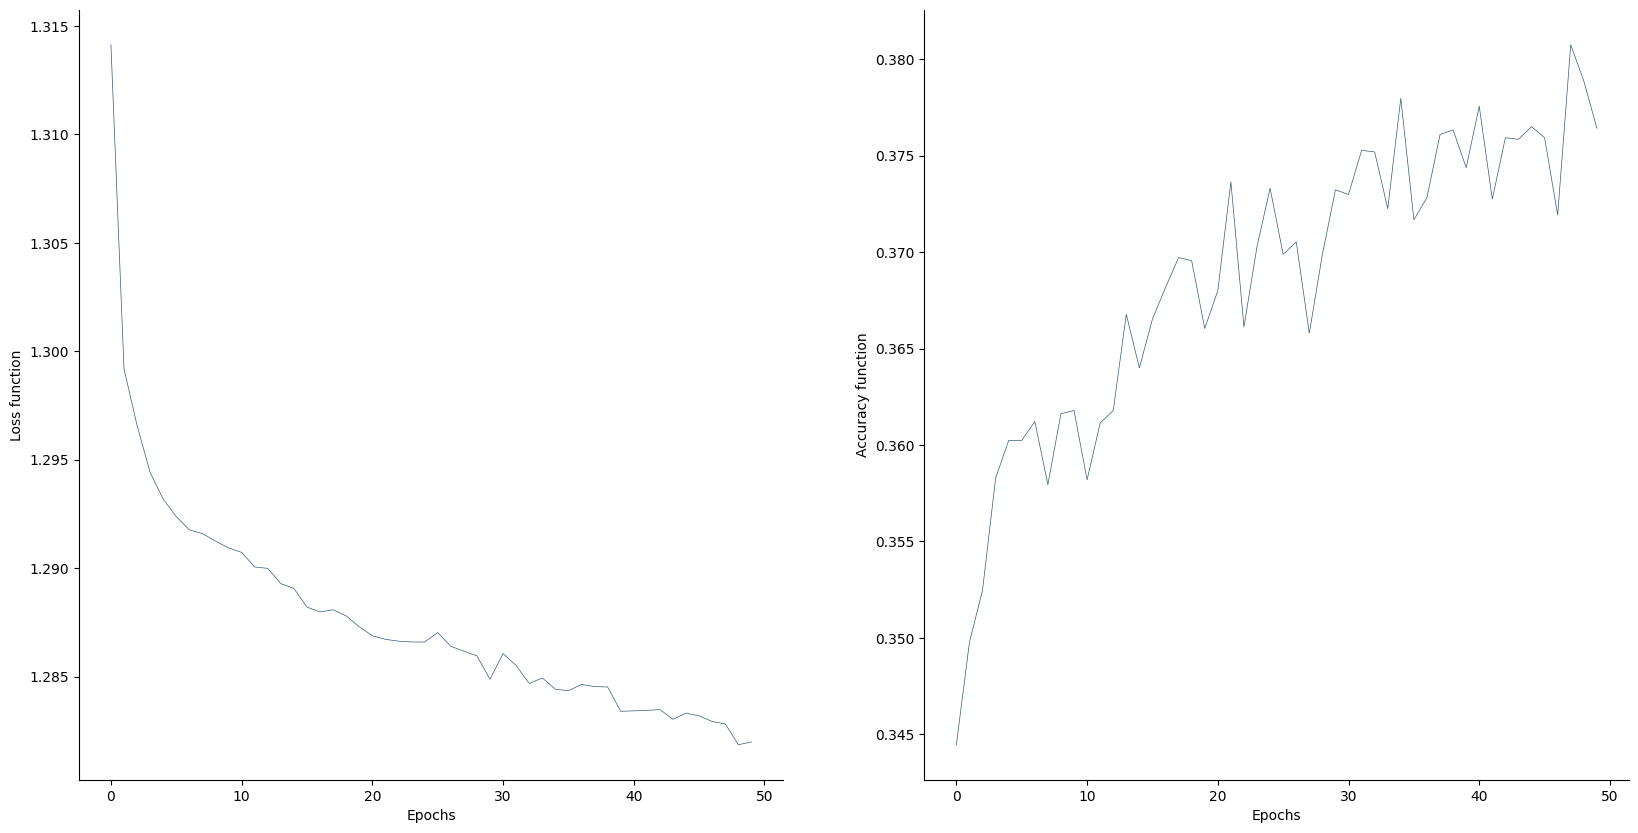

In [105]:
# %% View the training performance

fig = plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.plot(model_history.history['loss'])
plt.xlabel('Epochs'), plt.ylabel('Loss function')
plt.subplot(122)
plt.plot(model_history.history['accuracy'])
plt.xlabel('Epochs'), plt.ylabel('Accuracy function')

In [106]:
# %% Neural network weights
model.layers[0].get_weights()
# model.get_config() #model configuration
# %% View the model
plot_model(model)
# plot_model(model, to_file='../figures/P9_fig/model.png', show_shapes=True)
# %% Use the model
# Latest version
Y_prob = model.predict(X_test4)
Y_pred = np.argmax(Y_prob, axis=1)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
96/96 [==============================] - 1s 831us/step


InvalidIndexError: (0, slice(None, None, None))

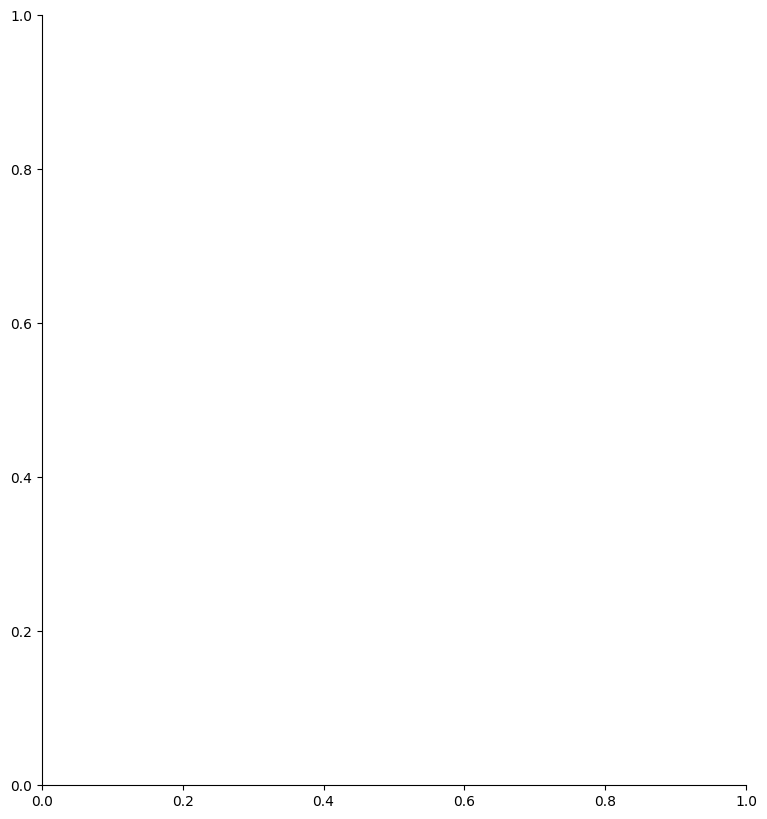

In [108]:
# %% View the neural network prediction
indx = 0
fig = plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(np.reshape(X_test4[indx, :], (8, 8)), cmap=plt.cm.gray_r)
plt.subplot(122)
plt.bar(np.arange(10), Y_prob[indx, :])
plt.ylim([0, 1])
plt.title('Prediction: %d' % np.argmax(Y_prob[indx, :]))

In [109]:
score = model.evaluate(X_test4, Y_test_dum, verbose=1)
print(score)

96/96 [==============================] - 1s 2ms/step - loss: 1.3623 - accuracy: 0.3157
[1.3623268604278564, 0.3156689703464508]


In [110]:
# %% More metrics

Yhat_train = np.argmax(model.predict(X_train4), axis=1)
Yhat_test = np.argmax(model.predict(X_test4), axis=1)
accu_train = accuracy_score(y_train4, Yhat_train)
prec_train = precision_score(y_train4, Yhat_train, average='weighted')
reca_train = recall_score(y_train4, Yhat_train, average='weighted')
accu_test = accuracy_score(y_test4, Yhat_test)
prec_test = precision_score(y_test4, Yhat_test, average='weighted')
reca_test = recall_score(y_test4, Yhat_test, average='weighted')
print(' \t\t Accu \t Prec \t Reca\n Train \t %0.3f \t %0.3f \t %0.3f\n  Test \t %0.3f \t %0.3f \t %0.3f' % (accu_train,
                                                                                                            prec_train,
                                                                                                            reca_train,
                                                                                                            accu_test,
                                                                                                            prec_test,
                                                                                                            reca_test))


96/96 [==============================] - 0s 1ms/step
 		 Accu 	 Prec 	 Reca
 Train 	 0.018 	 0.108 	 0.018
  Test 	 0.071 	 0.092 	 0.071


C:\Users\Emilio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Emilio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\Users\Emilio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\Emilio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Recall is ill-defined and be

## Scores

In [111]:
results = {'Accuracy': [accuracy_martingala, accuracy_logistic, accuracy_naive, accuracy_forest],
           'Recall': [recall_martingala, recall_logistic, recall_naive, recall_forest],
           'Precision': [precision_martingala, precision_logistic, precision_naive, precision_forest],
           'F1': [f1_martingala, f1_logistic, f1_naive, f1_forest],
           'Balanced Accuracy': [balanced_martingala, balanced_logistic, balanced_naive, balanced_forest]
           }

table = pd.DataFrame(results, index=['Martingale', 'Logistic Regression', 'Naive Bayes', 'Random Forest'])
print(table)

                      Accuracy     Recall  Precision         F1  \
Martingale           28.937729  28.937729  28.937715  28.937722   
Logistic Regression  34.380111  34.380111  34.344224  25.532177   
Naive Bayes          27.706902  27.706902  32.051493  25.704616   
Random Forest        32.908080  32.908080  33.027779  32.366589   

                     Balanced Accuracy  
Martingale                   28.062629  
Logistic Regression          27.164309  
Naive Bayes                  26.369913  
Random Forest                30.780981  
